#  COVID-19 Data Analysis
#### Simon Lindqvist, mail: siln22@student.bth.se
#### Abdalrahman Mohammed, mail: abmm22@student.bth.se

In [ ]:
# --------- IMPORTS ---------
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import statistics as stats
import math
import scipy.stats as st
import geopandas as gpd
from scipy.signal import correlate

# -- Read the data from the files --
death_case_df = pd.read_csv(".\Data analysis\Covid-19\Datasets\1.COVID-19_daily_number_of_new_cases_and_deaths.csv")
vaccinations_df = pd.read_csv(".\Data analysis\Covid-19\Datasets\2.COVID-19_vaccination.csv")
hosipital_df = pd.read_csv(".\Data analysis\Covid-19\Datasets\3.COVID-19_hospital_and_ICU_admission_rates.csv")

First the imports needed for this jupyter notebook are made. Make sure these are installed before running the notebook. This notebook will use Python 3.11.9, but other versions might work. After the imports the data is read from the csv files into pandas dataframes using the pd.read_csv function.

In [25]:
# --------- Data cleaning ---------

# -- Creating a copy of each dataset to preserve the original data --
death_case_df_clean = death_case_df.copy()
vaccinations_df_clean = vaccinations_df.copy()
hosipital_df_clean = hosipital_df.copy()

# -- Handle duplicates --
death_case_df_clean.drop_duplicates(inplace=True)
vaccinations_df_clean.drop_duplicates(inplace=True)
hosipital_df_clean.drop_duplicates(inplace=True)

# Remove all rows where ReportingCountry doesnt match Region (these are duplicate data). OBS! Very important step
vaccinations_df_clean = vaccinations_df_clean[vaccinations_df_clean["ReportingCountry"] == vaccinations_df_clean["Region"]]

# ---- Normalize data ----
# -- Death cases data --
death_case_df_clean["dateRep"] = pd.to_datetime(death_case_df_clean["dateRep"], format='%d/%m/%Y')
death_case_df_clean["day"] = pd.to_numeric(death_case_df_clean["day"])
death_case_df_clean["month"] = pd.to_numeric(death_case_df_clean["month"])
death_case_df_clean["year"] = pd.to_numeric(death_case_df_clean["year"]) 
death_case_df_clean["cases"] = pd.to_numeric(death_case_df_clean["cases"])
death_case_df_clean["deaths"] = pd.to_numeric(death_case_df_clean["deaths"])
death_case_df_clean["countriesAndTerritories"] = death_case_df_clean["countriesAndTerritories"].astype(str)
death_case_df_clean["geoId"] = death_case_df_clean["geoId"].astype(str)
death_case_df_clean["countryterritoryCode"] = death_case_df_clean["countryterritoryCode"].astype(str)
death_case_df_clean["popData2020"] = pd.to_numeric(death_case_df_clean["popData2020"])
death_case_df_clean["continentExp"] = death_case_df_clean["continentExp"].astype(str)

# -- Vaccinations data --
vaccinations_df_clean["YearWeekISO"] = pd.to_datetime(vaccinations_df_clean["YearWeekISO"] + '-1', format="%G-W%V-%u")
vaccinations_df_clean["ReportingCountry"] = vaccinations_df_clean["ReportingCountry"].astype(str)
vaccinations_df_clean["Denominator"] = pd.to_numeric(vaccinations_df_clean["Denominator"])
vaccinations_df_clean["NumberDosesReceived"] = pd.to_numeric(vaccinations_df_clean["NumberDosesReceived"])
vaccinations_df_clean["NumberDosesExported"] = pd.to_numeric(vaccinations_df_clean["NumberDosesExported"])
vaccinations_df_clean["FirstDose"] = pd.to_numeric(vaccinations_df_clean["FirstDose"])
vaccinations_df_clean["FirstDoseRefused"] = pd.to_numeric(vaccinations_df_clean["FirstDoseRefused"])
vaccinations_df_clean["SecondDose"] = pd.to_numeric(vaccinations_df_clean["SecondDose"])
vaccinations_df_clean["DoseAdditional1"] = pd.to_numeric(vaccinations_df_clean["DoseAdditional1"])
vaccinations_df_clean["DoseAdditional2"] = pd.to_numeric(vaccinations_df_clean["DoseAdditional2"])
vaccinations_df_clean["DoseAdditional3"] = pd.to_numeric(vaccinations_df_clean["DoseAdditional3"])
vaccinations_df_clean["DoseAdditional4"] = pd.to_numeric(vaccinations_df_clean["DoseAdditional4"])
vaccinations_df_clean["DoseAdditional5"] = pd.to_numeric(vaccinations_df_clean["DoseAdditional5"])
vaccinations_df_clean["UnknownDose"] = pd.to_numeric(vaccinations_df_clean["UnknownDose"])
vaccinations_df_clean["Region"] = vaccinations_df_clean["Region"].astype(str)
vaccinations_df_clean["TargetGroup"] = vaccinations_df_clean["TargetGroup"].astype(str)
vaccinations_df_clean["Vaccine"] = vaccinations_df_clean["Vaccine"].astype(str) 
vaccinations_df_clean["Population"] = pd.to_numeric(vaccinations_df_clean["Population"])

# -- Hospital data --
hosipital_df_clean["country"] = hosipital_df_clean["country"].astype(str)
hosipital_df_clean["indicator"] = hosipital_df_clean["indicator"].astype(str)
hosipital_df_clean["date"] = pd.to_datetime(hosipital_df_clean["date"])
hosipital_df_clean["year_week"] = pd.to_datetime(hosipital_df_clean["year_week"] + '-1', format="%G-W%V-%u")
hosipital_df_clean["value"] = pd.to_numeric(hosipital_df_clean["value"])
hosipital_df_clean["source"] = hosipital_df_clean["source"].astype(str)
hosipital_df_clean["url"] = hosipital_df_clean["url"].astype(str)

We start by making copies of the original dataframes to preserve an origninal version of each. We then drop duplicates. We also make sure that we only take rows where Region and Country code are the same, since some countries report for both, effectively duplicating their data.

We won't handle missing values in any way, since the data we are using is real world data, gathered by countries and handled by professional people. They are most likely already corrected if they are wrong, since a country unlikely would submit blatantly false data. We will assume that the data is reported correctly and that there is a reason for it being reported the way it is. Missing values probably means they didn't have any data, and interpolating, or setting the data to for example 0, would perchance alter any analysis done. 

The first dataset being cleaned is the death_case_df. We start by creating a copy of the original data to preserve it. We then remove any duplicate rows to ensure that our analysis isn't skewed by repeated data. We convert the "dateRep" column to a datetime format for easier manipulation and analysis. We also convert several columns to numeric types to enable mathematical operations. Finally, we convert some columns to string type to facilitate text-based operations. This cleaning process ensures that our data is in the correct format for analysis, and that we don't have any duplicate data that could distort our results.

The second dataset we clean is the vaccinations_df. Again, we start by creating a copy of the original data and removing any duplicates. We also remove rows where the reporting country doesn't match the region, as these are considered duplicate data. We convert the "YearWeekISO" column to a datetime format, and several other columns to numeric types. We also convert some columns to string type. This cleaning process ensures that our vaccination data is in the correct format for analysis, and that we don't have any duplicate data that could distort our results.

The third dataset we clean is the hosipital_df. We create a copy of the original data, remove duplicates, and convert the "date" and "year_week" columns to datetime format. We also convert the "value" column to a numeric type, and several other columns to string type. This cleaning process ensures that our hospital data is in the correct format for analysis, and that we don't have any duplicate data that could distort our results.

### Since 2020 till 2022, which top 10 countries reported the most number of cases of COVID-19 in quarters per year (Q1-Q4 in each year)? Do you find these numbers relatively high compared to the country’s population? Do you see any connection among these countries regarding their geographical locations and the period in which most cases are observed? Discuss your observations.

In [26]:
quarterly_cases_per_year = death_case_df_clean.groupby([death_case_df_clean["popData2020"], death_case_df_clean["countriesAndTerritories"], death_case_df_clean["year"], death_case_df_clean["month"] // 4])["cases"].sum()
sorted_quarterly_cases_per_year = quarterly_cases_per_year.sort_values(ascending=False).head(10)
for (popData2020, countriesAndTerritories, year, quarter), cases in sorted_quarterly_cases_per_year.items():
    print(f"Year: {year}, Quarter: {quarter + 1}, Total Cases: {cases}, Country: {countriesAndTerritories}, Population: {popData2020}, Percentage Of Cases/Population: {round(cases / popData2020 * 100, 2)}%")

Year: 2022, Quarter: 1, Total Cases: 15642043.0, Country: France, Population: 67320216, Percentage Of Cases/Population: 23.24%
Year: 2022, Quarter: 1, Total Cases: 14337869.0, Country: Germany, Population: 83166711, Percentage Of Cases/Population: 17.24%
Year: 2022, Quarter: 2, Total Cases: 9389615.0, Country: Germany, Population: 83166711, Percentage Of Cases/Population: 11.29%
Year: 2022, Quarter: 1, Total Cases: 8516671.0, Country: Italy, Population: 59641488, Percentage Of Cases/Population: 14.28%
Year: 2022, Quarter: 2, Total Cases: 8250631.0, Country: France, Population: 67320216, Percentage Of Cases/Population: 12.26%
Year: 2022, Quarter: 2, Total Cases: 6397671.0, Country: Italy, Population: 59641488, Percentage Of Cases/Population: 10.73%
Year: 2022, Quarter: 1, Total Cases: 4762082.0, Country: Spain, Population: 47332614, Percentage Of Cases/Population: 10.06%
Year: 2022, Quarter: 1, Total Cases: 4727250.0, Country: Netherlands, Population: 17407585, Percentage Of Cases/Popul

First we group our cleaned death case data by population, country, year, and quarter, summing up the cases for each group. We then sort these quarterly case totals in descending order and select the top 10. For each of these top 10 groups, we print out the year, quarter, total cases, country, population, and the percentage of cases relative to the population.

The percentages of cases relative to the population are quite high, with the Netherlands in Q1 2022 27.16% and France in Q1 2022 23.24% showing particularly high figures. Even the lower percentages, like Germany in Q3 2022 5.25% and France in Q3 2022 4.08%, are still significant given the populations involved. All the countries listed are in Europe. This indicates a significant impact of COVID-19 in Europe during the periods mentioned, particularly in Western Europe.The high numbers can be attributed to several factors, including population density, travel connections, and possibly the efficiency of reporting and testing. The first quarter of 2022 shows the highest case numbers across all countries mentioned. The case numbers decrease in the second and third quarters of 2022, reflecting either the impact of increased immunity from vaccination and previous infections, public health measures, or seasonal variations.

### Visualize each country’s total number of cases and deaths on a map plot using their geographical locations in 2020, 2021, and 2022. Discuss your observations.

C:\Users\abod1\AppData\Local\Temp\ipykernel_21096\3456864778.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


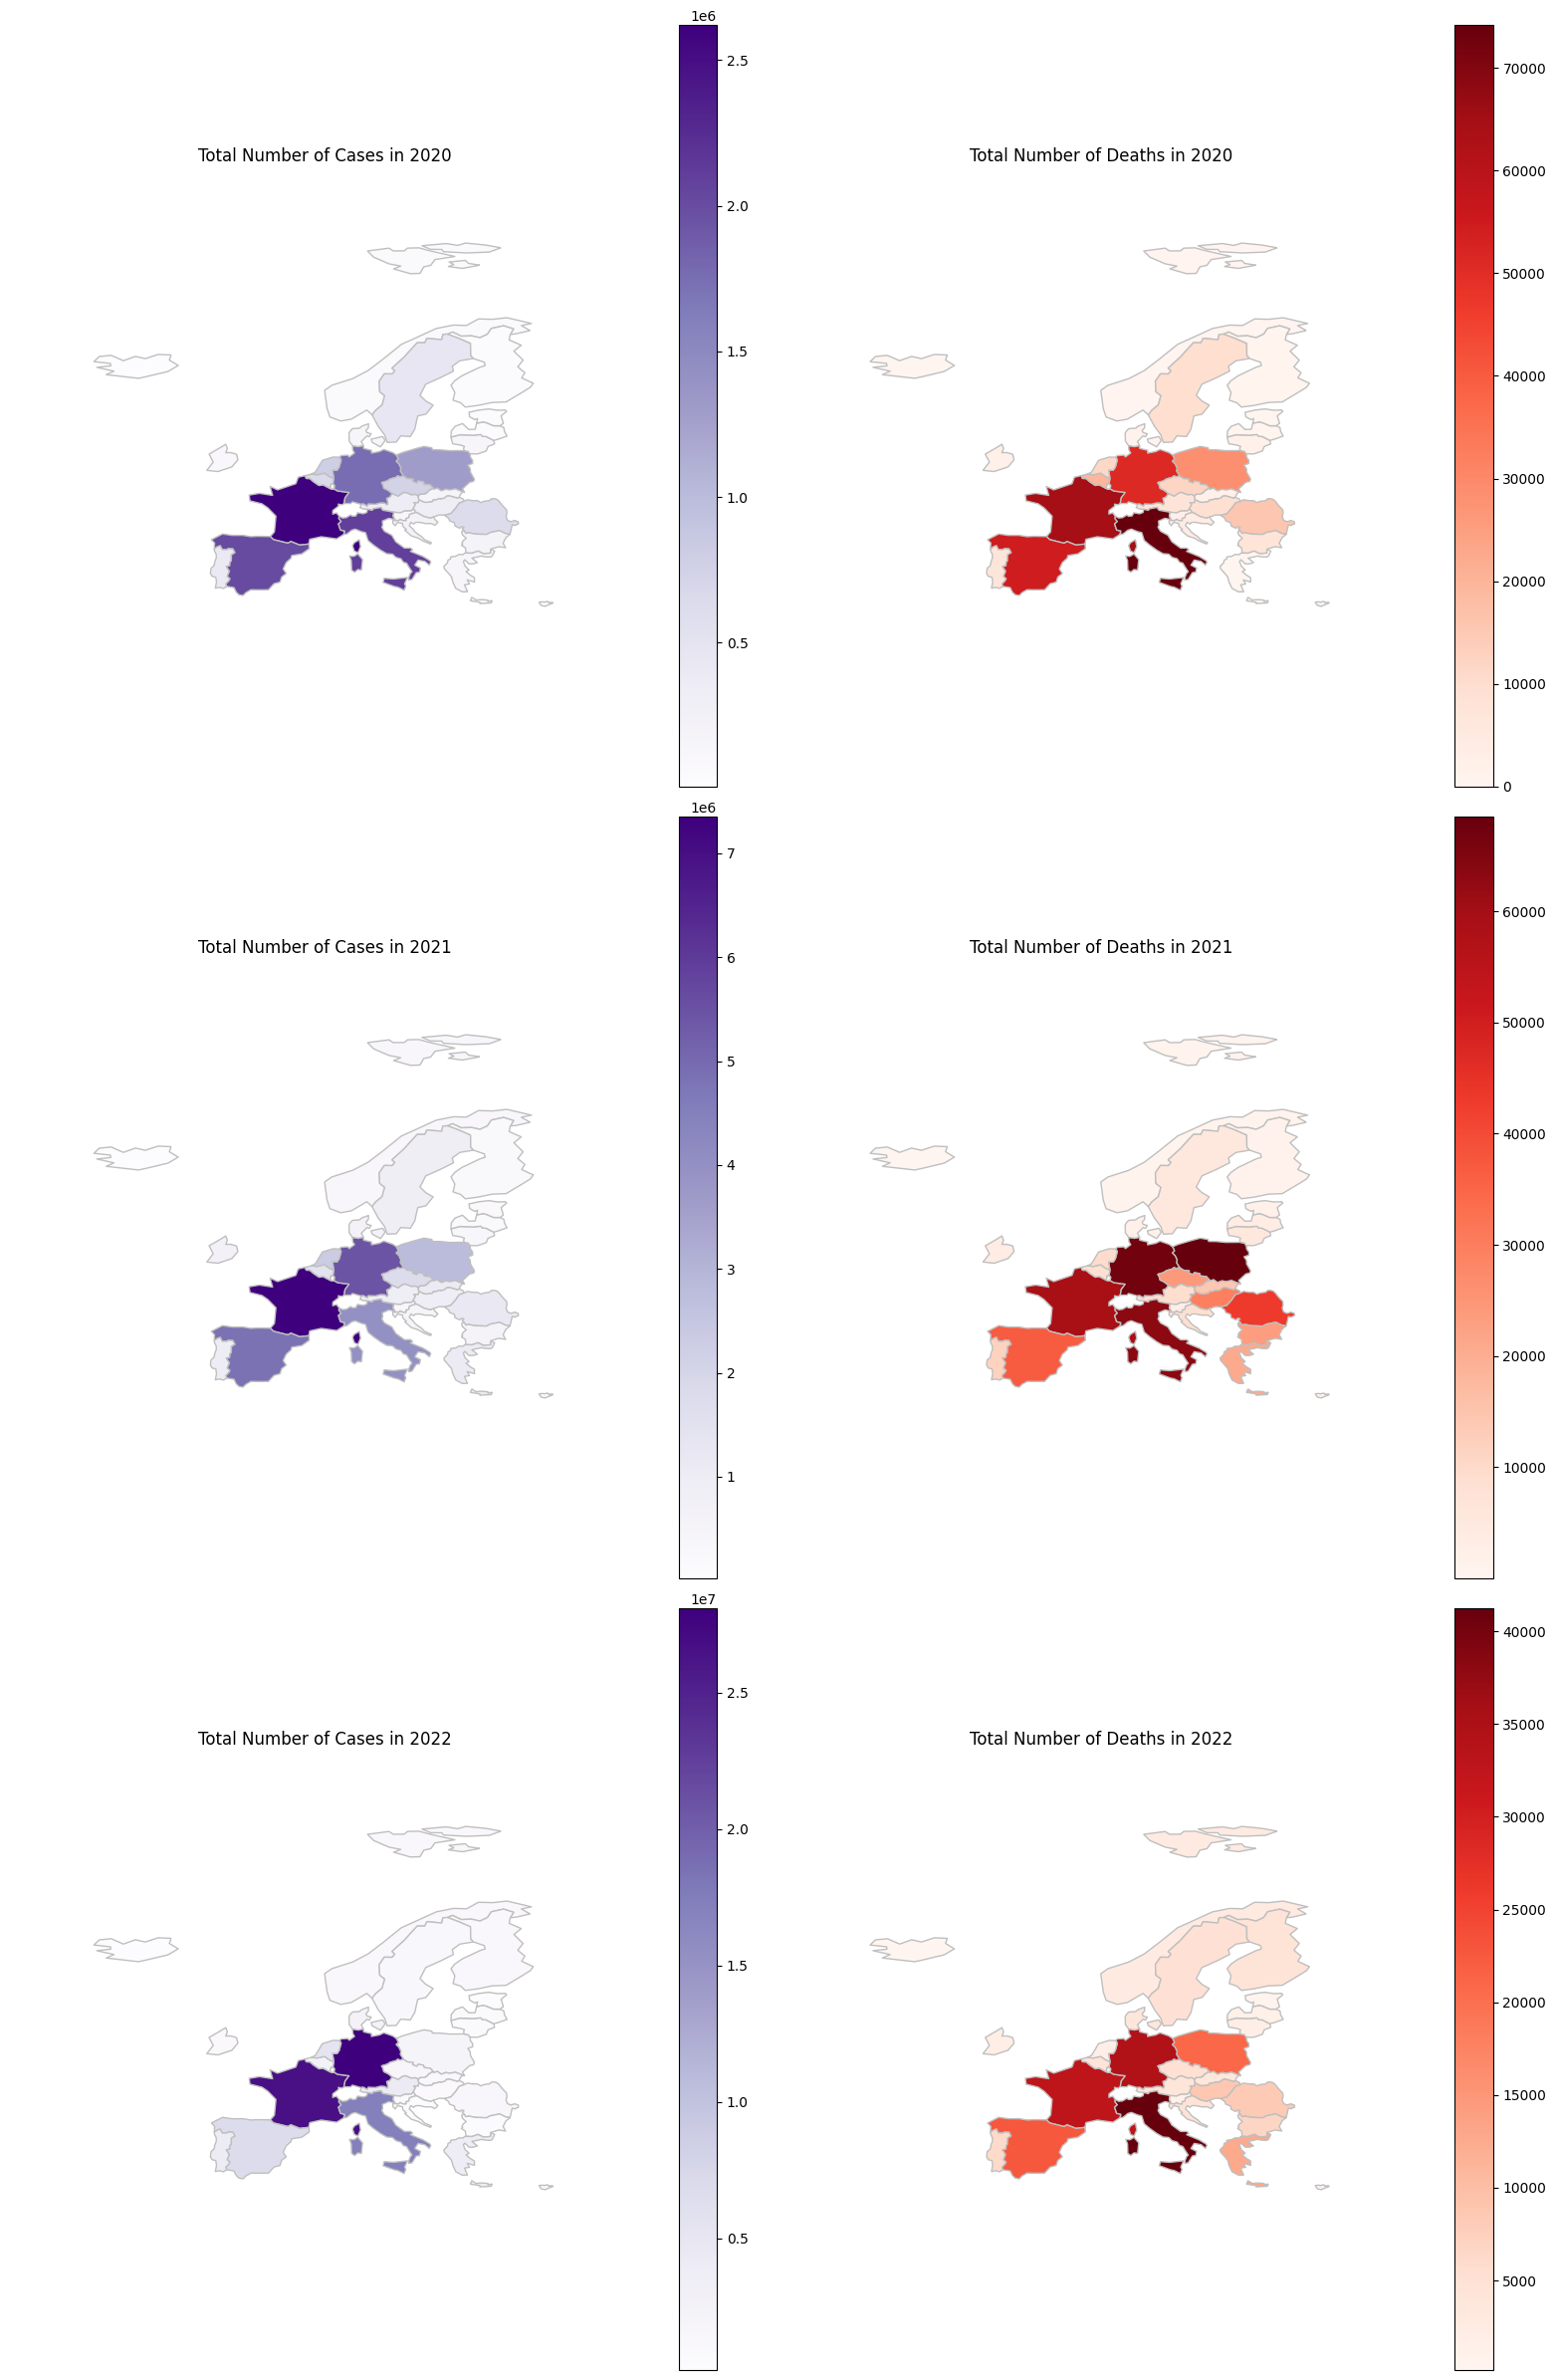

In [27]:
grouped_df_2020 = death_case_df_clean[death_case_df_clean['year'] == 2020].groupby(['countriesAndTerritories']).agg({'cases': 'sum', 'deaths': 'sum'})
grouped_df_2021 = death_case_df_clean[death_case_df_clean['year'] == 2021].groupby(['countriesAndTerritories']).agg({'cases': 'sum', 'deaths': 'sum'})
grouped_df_2022 = death_case_df_clean[death_case_df_clean['year'] == 2022].groupby(['countriesAndTerritories']).agg({'cases': 'sum', 'deaths': 'sum'})

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

merged_data_2020 = world.merge(grouped_df_2020, how='left', left_on='name', right_on='countriesAndTerritories')
merged_data_2021 = world.merge(grouped_df_2021, how='left', left_on='name', right_on='countriesAndTerritories')
merged_data_2022 = world.merge(grouped_df_2022, how='left', left_on='name', right_on='countriesAndTerritories')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = mpl.subplots(3, 2, figsize=(16, 24))

merged_data_2020.plot(column='cases', cmap='Purples', linewidth=1, ax=ax1, edgecolor='0.75', legend=True)
ax1.set_title('Total Number of Cases in 2020')
ax1.axis('off')
ax1.set_xlim(-35, 45)
ax1.set_ylim(30, 90)

merged_data_2020.plot(column='deaths', cmap='Reds', linewidth=1, ax=ax2, edgecolor='0.75', legend=True)
ax2.set_title('Total Number of Deaths in 2020')
ax2.axis('off')
ax2.set_xlim(-35, 45)
ax2.set_ylim(30, 90)

merged_data_2021.plot(column='cases', cmap='Purples', linewidth=1, ax=ax3, edgecolor='0.75', legend=True)
ax3.set_title('Total Number of Cases in 2021')
ax3.axis('off')
ax3.set_xlim(-35, 45)
ax3.set_ylim(30, 90)

merged_data_2021.plot(column='deaths', cmap='Reds', linewidth=1, ax=ax4, edgecolor='0.75', legend=True)
ax4.set_title('Total Number of Deaths in 2021')
ax4.axis('off')
ax4.set_xlim(-35, 45)
ax4.set_ylim(30, 90)

merged_data_2022.plot(column='cases', cmap='Purples', linewidth=1, ax=ax5, edgecolor='0.75', legend=True)
ax5.set_title('Total Number of Cases in 2022')
ax5.axis('off')
ax5.set_xlim(-35, 45)
ax5.set_ylim(30, 90)

merged_data_2022.plot(column='deaths', cmap='Reds', linewidth=1, ax=ax6, edgecolor='0.75', legend=True)
ax6.set_title('Total Number of Deaths in 2022')
ax6.axis('off')
ax6.set_xlim(-35, 45)
ax6.set_ylim(30, 90)

mpl.tight_layout()
mpl.show()

First cleaned death/case data is grouped by country for each year (2020, 2021, and 2022), summing up the cases and deaths for each group. We then load a world map using geopandas and merge our grouped data with this map for each year. We create a 3x2 grid of plots, with each row representing a year and each column representing either total cases or total deaths. We plot the total cases and deaths on the world map for each year, using different color maps for cases and deaths. 

##### 2020:
- **Most Cases:** France reported the highest number of cases.
- **Geographical Trend:** Western European countries, including France, Germany, Spain and Italy, reported high case numbers.
- **Most Deaths:** Italy had the highest number of deaths, indicating a severe impact early in the pandemic.
- **Geographical Trend for Deaths:** The highest death tolls were concentrated in Italy and other parts of Western Europe.
##### 2021:
- **Most Cases:** France continued to report the highest number of cases.
- **Geographical Trend:** Western Europe remained significantly affected, with high case numbers in France, Spain, Germany, and Italy.
- **Most Deaths:** Germany and Belarus reported the highest number of deaths.
- **Geographical Trend for Deaths:** Most deaths occurred in Western Europe, with a notable increase in Germany and Belarus.
##### 2022:
- **Most Cases:** Both France and Germany reported the highest number of cases.
- **Geographical Trend:** Western Europe continued to be heavily impacted, with significant case numbers in France, Germany, and Italy.
- **Most Deaths:** Italy again reported the highest number of deaths.
- **Geographical Trend for Deaths:** The majority of deaths were concentrated in Western Europe, with Italy seeing the highest death toll.

### What are the top 3 popular vaccine brands that have been used across the EU/EEA? Can you observe the same popularity at the country level? Are there any exceptions?

In [28]:
dose_types = ['FirstDose', 'SecondDose', 'DoseAdditional1', 'DoseAdditional2', 'DoseAdditional3', 'DoseAdditional4', 'DoseAdditional5', 'UnknownDose']

li = ["ALL", "Age<18", "HCW", "LTCF", "AgeUNK", "1_Age<60", "1_Age60+"]
vaccinations_df_clean_tg = vaccinations_df_clean[~vaccinations_df_clean["TargetGroup"].isin(li)]

vaccine_grouped_df = vaccinations_df_clean_tg.groupby('Vaccine')[dose_types].sum(numeric_only=True)
country_vaccine_grouped_df = vaccinations_df_clean_tg.groupby(['ReportingCountry', 'Vaccine'])[dose_types].sum()

vaccine_grouped_df['TotalDoses'] = vaccine_grouped_df.sum(axis=1)
country_vaccine_grouped_df['TotalDoses'] = country_vaccine_grouped_df.sum(axis=1)

print("Top 3 vaccines overall: (Not taking UNK into account)")
top_vaccines_overall = vaccine_grouped_df['TotalDoses'].sort_values(ascending=False).head(4)
for vaccine, total_doses in top_vaccines_overall.items():
    print(f"Vaccine: {vaccine}, Total Doses: {total_doses}")
            
for country in vaccinations_df_clean_tg['ReportingCountry'].unique():
    print(f"\nTop 3 vaccines in {country}:")
    top_vaccines_country = country_vaccine_grouped_df.loc[country]['TotalDoses'].sort_values(ascending=False).head(3)
    for vaccine, total_doses in top_vaccines_country.items():
        print(f"Vaccine: {vaccine}, Total Doses: {total_doses}")

Top 3 vaccines overall: (Not taking UNK into account)
Vaccine: COM, Total Doses: 408859510
Vaccine: UNK, Total Doses: 151517223
Vaccine: MOD, Total Doses: 102899902
Vaccine: AZ, Total Doses: 48146910

Top 3 vaccines in AT:
Vaccine: COM, Total Doses: 15841899
Vaccine: MOD, Total Doses: 1648880
Vaccine: AZ, Total Doses: 1593241

Top 3 vaccines in BE:
Vaccine: COM, Total Doses: 16536563
Vaccine: MOD, Total Doses: 4304881
Vaccine: COMBA.1, Total Doses: 3043560

Top 3 vaccines in BG:
Vaccine: COM, Total Doses: 3034609
Vaccine: JANSS, Total Doses: 531021
Vaccine: MOD, Total Doses: 510405

Top 3 vaccines in CY:
Vaccine: COM, Total Doses: 1334669
Vaccine: AZ, Total Doses: 254540
Vaccine: MOD, Total Doses: 200237

Top 3 vaccines in CZ:
Vaccine: COM, Total Doses: 15117319
Vaccine: MOD, Total Doses: 1632785
Vaccine: AZ, Total Doses: 886180

Top 3 vaccines in DK:
Vaccine: COM, Total Doses: 11265664
Vaccine: MOD, Total Doses: 1779307
Vaccine: COMBA.4-5, Total Doses: 1187112

Top 3 vaccines in EE:
V

Firstly we filter out certain age groups from our vaccination data. We group the cleaned data by vaccine type and sum up the doses for each vaccine. We also group the data by country and vaccine type, summing up the doses for each group. We then calculate the total doses for each vaccine and for each country-vaccine pair. We print out the top 3 vaccines overall, excluding the 'Unknown' category. For each unique country in our data, we print out the top 3 vaccines and the total doses administered for each.

Findings:
- **Overall Popularity:**
The most popular vaccine across the EU/EEA is Pfizer BioNTech – Comirnaty (COM), followed by Moderna – Spikevax (MOD) and AstraZeneca - Vaxzevria (AZ)
- **Country-Level Consistency:**
    - Pfizer BioNTech – Comirnaty (COM) is the top vaccine in almost all countries, reflecting its widespread acceptance and use.
    - Moderna – Spikevax (MOD) is consistently within the top three vaccines in most countries, indicating its significant role in vaccination campaigns.
    - AstraZeneca - Vaxzevria (AZ) is also popular, although its position varies, being the second or third most used in several countries.
- **Exceptions:**
    - France is an outlier with UNK (Unknown) listed as the top vaccine, which could indicate different reporting standards.
    - Hungary shows a unique pattern with Beijing CNBG - BBIBP-CorV (BECNBG) and Gamaleya - Sputnik-V (SPU) among the top three, reflecting Hungary’s broader acceptance of non-EU vaccines.
    - Belgium and Denmark feature Pfizer BioNTech - Comirnaty Original/Omicron BA.1 (COMBA.1) and Pfizer BioNTech – Comirnaty Original/Omicron BA.4/BA.5 (COMBA.4-5), indicating a preference for updated versions of the Pfizer-BioNTech vaccine.
    - Liechtenstein has Moderna as the top vaccine, which is less common compared to other EU/EEA countries where Comirnaty generally dominates.
- We did not exclude unspecified vaccines (UNK) from our analysis, as their presence could indicate data aggregation issues or differing reporting standards. We retained this category because it provides an interesting insight into potential variations in vaccine reporting practices.

### Considering the previous question, which target groups mainly received these vaccine brands in each country?

In [29]:
dose_types = ['FirstDose', 'SecondDose', 'DoseAdditional1', 'DoseAdditional2', 'DoseAdditional3', 'DoseAdditional4', 'DoseAdditional5', 'UnknownDose']

li = ["ALL", "Age<18", "HCW", "LTCF", "AgeUNK", "1_Age<60", "1_Age60+"]
vaccinations_df_clean_tg = vaccinations_df_clean[~vaccinations_df_clean["TargetGroup"].isin(li)]

country_vaccine_grouped_df = vaccinations_df_clean_tg.groupby(['ReportingCountry', 'Vaccine'])[dose_types].sum()
country_vaccine_grouped_df['TotalDoses'] = country_vaccine_grouped_df.sum(axis=1)

grouped_by_target_df = vaccinations_df_clean_tg.groupby(['ReportingCountry', 'Vaccine', 'TargetGroup'])[dose_types].sum()
for country in vaccinations_df_clean_tg['ReportingCountry'].unique():
    print(f"\nTop 3 vaccines and Their Target Age Group in {country}:")
    top_vaccines_country = country_vaccine_grouped_df.loc[country]['TotalDoses'].sort_values(ascending=False).head(3)
    
    for vaccine, total_doses in top_vaccines_country.items():
        print(f"Vaccine: {vaccine}, Total Doses: {total_doses}")
        top_target_age_groups = grouped_by_target_df.loc[(country, vaccine)].sum(axis=1).sort_values(ascending=False).head(3)
        print("  Top Target Age Groups:")
        for target_age_group, total_doses_age_group in top_target_age_groups.items():
            print(f"    - Age Group: {target_age_group}, Total Doses: {total_doses_age_group}")


Top 3 vaccines and Their Target Age Group in AT:
Vaccine: COM, Total Doses: 15841899
  Top Target Age Groups:
    - Age Group: Age25_49, Total Doses: 5233774
    - Age Group: Age50_59, Total Doses: 2662352
    - Age Group: Age60_69, Total Doses: 2329576
Vaccine: MOD, Total Doses: 1648880
  Top Target Age Groups:
    - Age Group: Age25_49, Total Doses: 619900
    - Age Group: Age50_59, Total Doses: 386625
    - Age Group: Age60_69, Total Doses: 251426
Vaccine: AZ, Total Doses: 1593241
  Top Target Age Groups:
    - Age Group: Age25_49, Total Doses: 519833
    - Age Group: Age50_59, Total Doses: 332341
    - Age Group: Age60_69, Total Doses: 310859

Top 3 vaccines and Their Target Age Group in BE:
Vaccine: COM, Total Doses: 16536563
  Top Target Age Groups:
    - Age Group: Age25_49, Total Doses: 5794285
    - Age Group: Age60_69, Total Doses: 2789007
    - Age Group: Age50_59, Total Doses: 2555680
Vaccine: MOD, Total Doses: 4304881
  Top Target Age Groups:
    - Age Group: Age25_49, To

We first define the types of doses we're interested in. We then filter out certain age groups from our vaccination data. We group the cleaned data by country and vaccine type, summing up the doses for each group. We also calculate the total doses for each group.Then the data is grouped again, this time by country, vaccine, and target age group, and sum up the doses for each group. For each unique country in our data, we print out the top 3 vaccines and their target age groups. For each of these vaccines, we also print out the top 3 target age groups and the total doses administered to each group. Use the scrollable element button to view all data.

We found that:
- Pfizer BioNTech – Comirnaty (COM): The most frequently administered vaccine across all listed countries, with the highest number of doses in the age group 25-49, followed by 50-59 and 60-69 age     groups.
- Moderna – Spikevax (MOD): Also widely administered, particularly in the 25-49 age group, but generally less than Comirnaty. The 60-69 and 50-59 age groups also received significant numbers of Moderna 
- AstraZeneca - Vaxzevria (AZ): Predominantly administered to older age groups (60-69 and 70-79), but in some countries, it was also used significantly in the 25-49 age group.

### Which countries are the most skeptical towards the first dose of the COVID-19 vaccine? Do you think this matter had any impact on the hospitalization level?

In [30]:
Refused_First_Dose_df = vaccinations_df_clean.groupby(['ReportingCountry', "YearWeekISO"])["FirstDoseRefused"].sum() # Group by country and week
Refused_First_Dose_df = Refused_First_Dose_df[Refused_First_Dose_df != 0] # Remove all rows where FirstDoseRefused is 0

# Print Refused_First_Dose_df in a nice format
for (country, week), refused_doses in Refused_First_Dose_df.items():
    print(f"Country: {country}, Week: {week}, Refused First Doses: {refused_doses}")


Country: IS, Week: 2021-02-08 00:00:00, Refused First Doses: 21.0
Country: IS, Week: 2021-02-15 00:00:00, Refused First Doses: 34.0
Country: IS, Week: 2021-02-22 00:00:00, Refused First Doses: 55.0
Country: IS, Week: 2021-03-01 00:00:00, Refused First Doses: 48.0
Country: IS, Week: 2021-03-08 00:00:00, Refused First Doses: 98.0
Country: IS, Week: 2021-03-15 00:00:00, Refused First Doses: 30.0
Country: IS, Week: 2021-03-22 00:00:00, Refused First Doses: 40.0
Country: IS, Week: 2021-03-29 00:00:00, Refused First Doses: 39.0
Country: IS, Week: 2021-04-12 00:00:00, Refused First Doses: 12.0
Country: IS, Week: 2021-04-19 00:00:00, Refused First Doses: 56.0
Country: IS, Week: 2021-04-26 00:00:00, Refused First Doses: 148.0


The dataset reveals numerous missing values in the column for first dose refusals. Notably, Iceland is the only country with reported instances of refusing the first dose, indicating either a degree of skepticism, or a unique enthusiasm for reporting peoples unwillingness to vaccinate. Incomplete data prevents a thorough assessment of vaccine hesitancy in other countries. Assessment of Iceland alone will be made in order to get any conclusions at all.

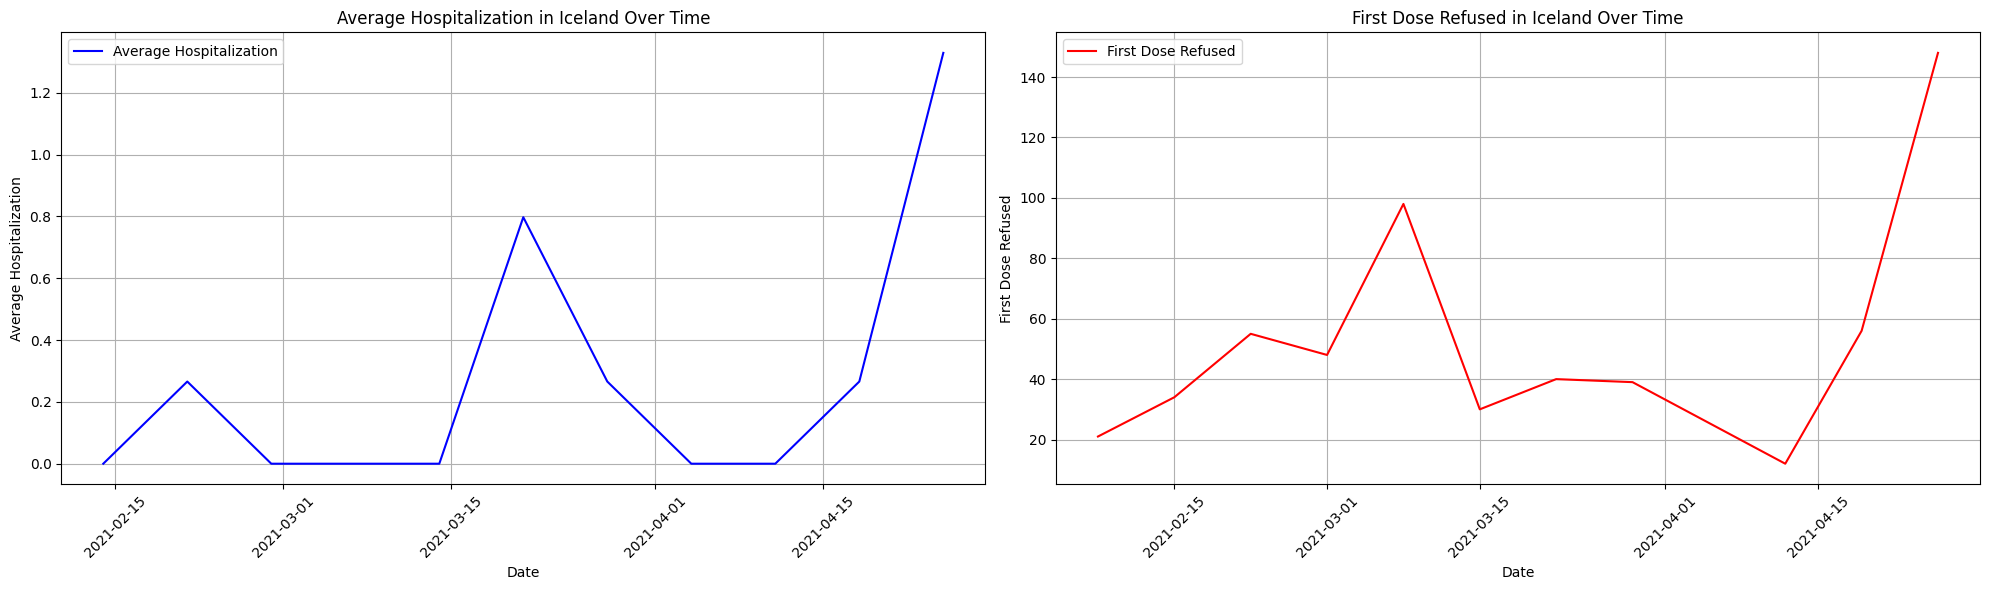

In [31]:
hosipital_df_clean_iceland = hosipital_df_clean[hosipital_df_clean["country"] == "Iceland"] # Filter out only Iceland data

average_hospitalization = hosipital_df_clean_iceland.groupby(['country', 'date'])['value'].mean().reset_index()
# Make sure that both plot between the same dates
average_hospitalization = average_hospitalization[average_hospitalization['date'].between(Refused_First_Dose_df.index.get_level_values('YearWeekISO').min(), Refused_First_Dose_df.index.get_level_values('YearWeekISO').max())]


# Create a figure and a grid of subplots
fig, ax = mpl.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 'Average Hospitalization' on the first subplot
ax[0].plot(average_hospitalization['date'], average_hospitalization['value'], color='blue', label='Average Hospitalization')
ax[0].set_title('Average Hospitalization in Iceland Over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Average Hospitalization')
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].grid(True)
ax[0].legend()

# Plot 'First Dose Refused' on the second subplot
ax[1].plot(Refused_First_Dose_df.index.get_level_values('YearWeekISO'), Refused_First_Dose_df.values, color='red', label='First Dose Refused')
ax[1].set_title('First Dose Refused in Iceland Over Time')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('First Dose Refused')
ax[1].xaxis.set_tick_params(rotation=45)
ax[1].grid(True)
ax[1].legend()

# Adjust the layout
fig.tight_layout()
mpl.show()


Analysis of the dataset reveals a period of vaccine refusals in Iceland from February 8, 2021, to April 26, 2021, as depicted in the plot "First Dose Refused in Iceland Over Time." Correspondingly, the plot "Average Hospitalization in Iceland Over Time" displays three distinct spikes in hospitalization rates during this period. This alignment suggests a potential correlation between the refusal of the first dose and subsequent rises in hospitalizations. Such correlation could underscore the significance of widespread vaccine acceptance in managing public health.

Correlation between 'Average Hospitalization' and 'First Dose Refused': 0.6059243311945723


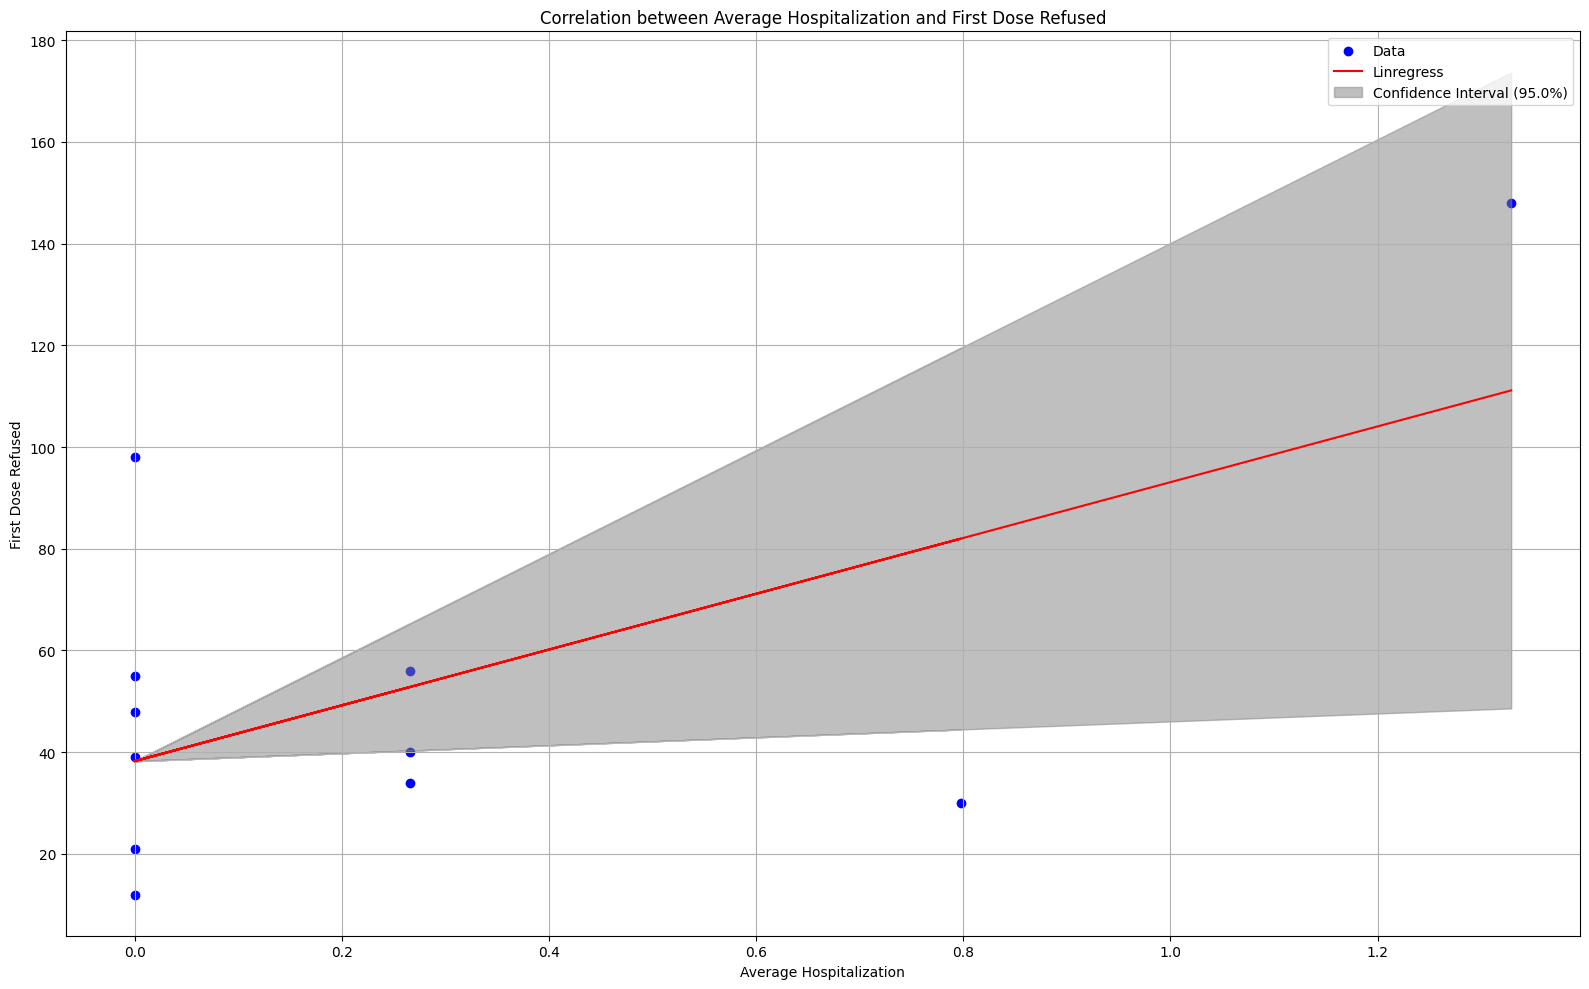

In [32]:
# Is there any correlation between them?
# Calculate the correlation between 'Average Hospitalization' and 'First Dose Refused'
date_and_value_dict_hospitalization = dict(zip(average_hospitalization['date'], average_hospitalization['value']))
date_and_value_dict_refused = dict(zip(Refused_First_Dose_df.index.get_level_values('YearWeekISO'), Refused_First_Dose_df.values))

# Find any correlation between the two datasets
correlation = st.pearsonr(list(date_and_value_dict_hospitalization.values()), list(date_and_value_dict_refused.values()))
print(f"Correlation between 'Average Hospitalization' and 'First Dose Refused': {correlation[0]}")

# Plot the correlation linregress
slope, intercept, r_value, p_value, std_err = st.linregress(list(date_and_value_dict_hospitalization.values()), list(date_and_value_dict_refused.values()))
# Calculate confidence interval
confidence_interval = 0.95
z_score = st.norm.ppf((1 + confidence_interval) / 2)
margin_of_error = z_score * std_err

upper_bound = slope + margin_of_error
lower_bound = slope - margin_of_error

# Create a figure and a grid of subplots
fig, ax = mpl.subplots(figsize=(16, 10))

# Plot the correlation linregress
ax.scatter(list(date_and_value_dict_hospitalization.values()), list(date_and_value_dict_refused.values()), color='blue', label='Data')
ax.plot(list(date_and_value_dict_hospitalization.values()), slope * np.array(list(date_and_value_dict_hospitalization.values())) + intercept, color='red', label='Linregress')
ax.fill_between(list(date_and_value_dict_hospitalization.values()), lower_bound * np.array(list(date_and_value_dict_hospitalization.values())) + intercept, upper_bound * np.array(list(date_and_value_dict_hospitalization.values())) + intercept, color='gray', alpha=0.5, label=f'Confidence Interval ({confidence_interval * 100}%)')
ax.set_title('Correlation between Average Hospitalization and First Dose Refused')
ax.set_xlabel('Average Hospitalization')
ax.set_ylabel('First Dose Refused')
ax.grid(True)
ax.legend()

# Adjust the layout
fig.tight_layout()
mpl.show()

A correlation plot was generated to explore the link between average hospitalization rates and first dose refusals in Iceland, revealing a correlation coefficient of 0.6059. This indicates a moderate positive correlation, implying that refusing the first dose of the COVID-19 vaccine may lead to higher hospitalization levels. The coefficient highlights the importance of vaccine acceptance in relieving strain on healthcare systems and emphasizes the need for targeted interventions to address vaccine hesitancy.

We will also examine what percentages of people in all countries took the first dose in each country, where a lower percentage could indicate that the country has a higher rate of refusal. This isn't definitive though, as a lower percentage could mean that the country can't administrate vaccines as efficient too. It's however necesarry to look into this metric, since the data on refusals is so bad. 

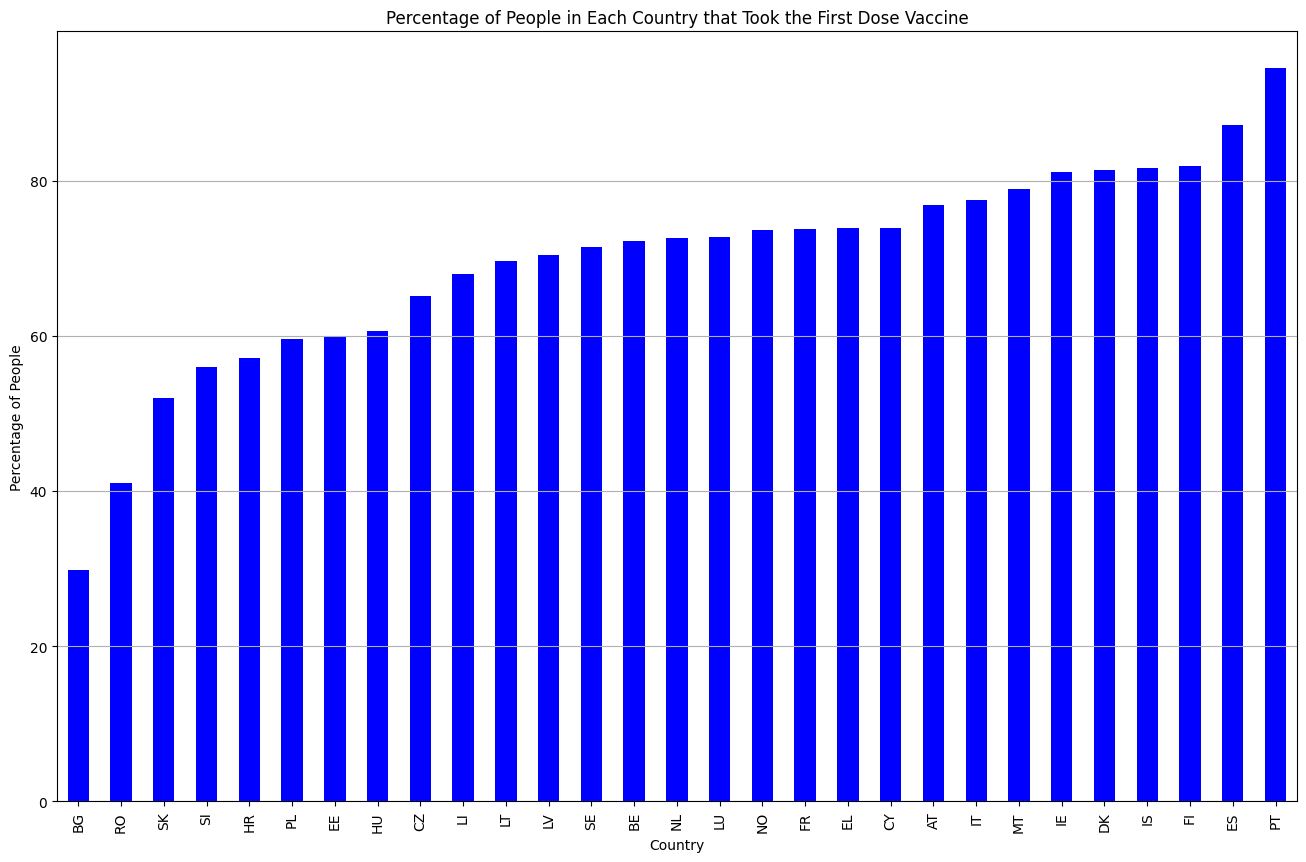

In [33]:
# -- Calculate the percentage of people in each country that took the first dose vaccine --

# Remove data from duplicate age groups
li = ["ALL", "Age<18", "HCW", "LTCF", "AgeUNK", "1_Age<60", "1_Age60+"] # List of age groups to remove
vaccinations_df_clean_tg = vaccinations_df_clean[~vaccinations_df_clean["TargetGroup"].isin(li)] # Remove all rows where TargetGroup is in li

# Calculate the total number of first doses for each country
total_first_doses = vaccinations_df_clean_tg.groupby('ReportingCountry')['FirstDose'].sum()
# Make sure country code = region code

# Calculate the total population for each country
total_population = vaccinations_df_clean_tg.groupby('ReportingCountry')['Population'].max()

# Calculate the percentage of people in each country that took the first dose vaccine for each year (2020, 2021, 2022, 2023)
percentage_first_doses = (total_first_doses / total_population) * 100

# Sort ascending
percentage_first_doses = percentage_first_doses.sort_values(ascending=True)

# Plot the percentage of people in each country that took the first dose vaccine
percentage_first_doses.plot(kind='bar', figsize=(16, 10), color='blue')
mpl.title('Percentage of People in Each Country that Took the First Dose Vaccine')
mpl.xlabel('Country')
mpl.ylabel('Percentage of People')
mpl.grid(axis='y')
mpl.show()


First we eliminate duplicate age groups from our vaccination data. We then calculate the total number of first doses administered in each country. We also determine the total population for each country. Using these two figures, we calculate the percentage of people in each country that have received the first dose of the vaccine. Finally, we sort these percentages in ascending order, which allows us to easily identify the countries with the lowest vaccination rates easier in the plot.

In the plot we see that Iceland does have one of the largest percentages, meaning that they probably aren't that sceptical, even though they are the only ones reporting the data. Instead it seems like Romania and Bulgaria has the lowest percentages, meaning they might be more sceptic against vaccines (or that the countries doesn't administrate vaccines in an effective manner).

### Rank all EU/EEA countries, based on their vaccinated population under age 18 for the first dose of the COVID-19 vaccine, which countries have the most and least vaccinated people under age 18 in regards to their total populations?

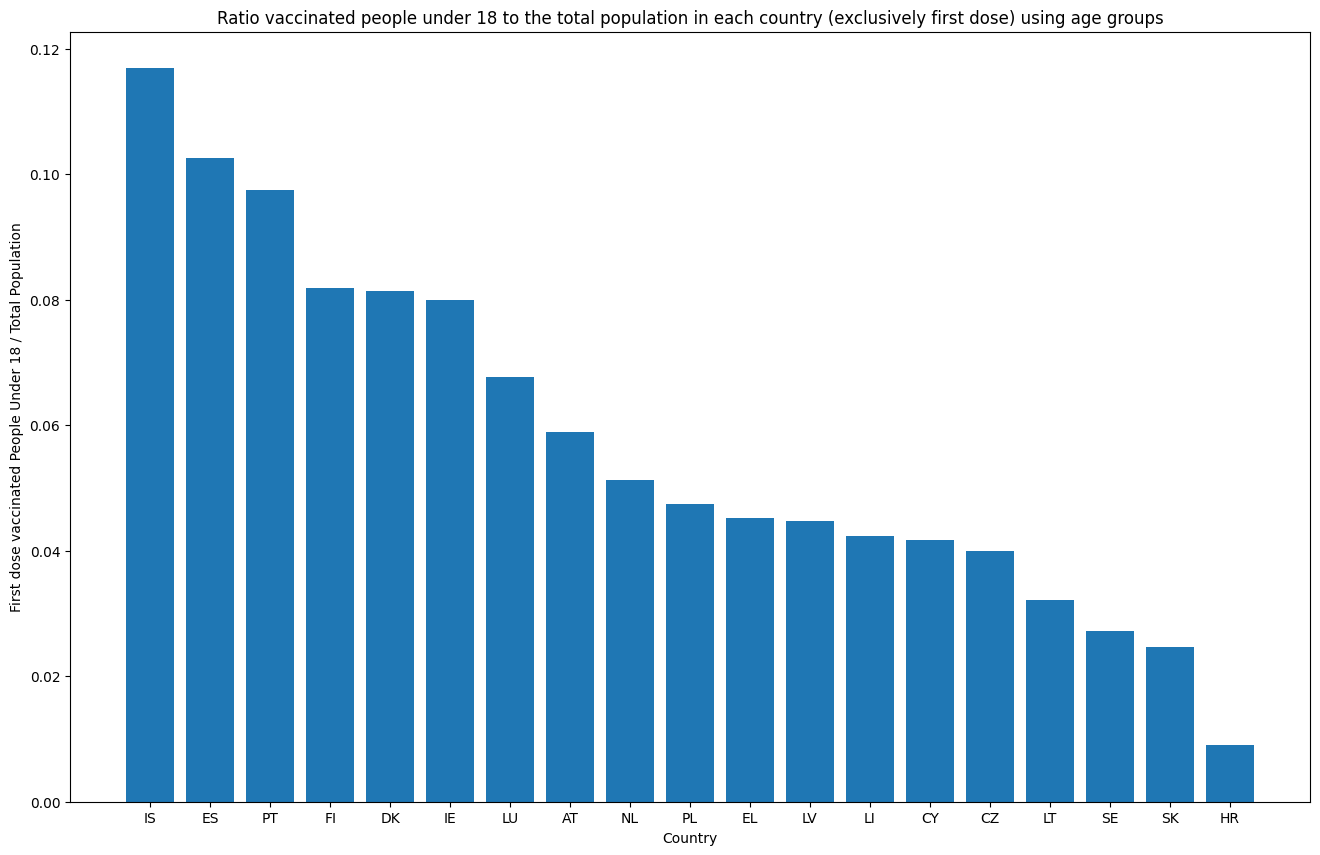

In [34]:
# Gather vaccinated population under 18
vaccinated_under_18 = pd.DataFrame(columns=vaccinations_df_clean.columns) # Create empty dataframe to store vaccinated people under 18
under_18_age_groups = ["Age0_4", "Age5_9", "Age10_14", "Age15_17"] # Define age groups for people under 18
for age_group in under_18_age_groups:
    # Add people of current age group to vaccinated_under_18 dataframe using concat.
    vaccinated_under_18 = pd.concat([vaccinated_under_18, vaccinations_df_clean[vaccinations_df_clean["TargetGroup"] == age_group]])

# Get all countries in dataset
countries = vaccinated_under_18["ReportingCountry"].unique() # Get unique countries in the dataset
# Get number of vaccinated people under 18 in each country (from first dose)
vaccinated_under_18_per_country = {} # Create empty dict to store vaccinated people under 18 for each country
for country in countries: # Loop through each country
    # Sum the first dose vaccines to gather total number of vaccinated (first dose) people under 18 in each country
    vaccinated_under_18_per_country[country] = vaccinated_under_18[vaccinated_under_18["ReportingCountry"] == country]["FirstDose"].sum()

# Calculate the ratio of vaccinated people under 18 to the total population in each country
vaccinated_under_18_ratio_per_country = {} # Create empty dict to store vaccinated people under 18/total population ratios for each country
for country in countries: # Loop through each country
    # Get the total population of the country
    total_population = vaccinations_df_clean[vaccinations_df_clean["ReportingCountry"] == country]["Population"].iloc[0]
    # Calculate the ratio of vaccinated people under 18 to the total population
    vaccinated_under_18_ratio_per_country[country] = vaccinated_under_18_per_country[country] / total_population

# Sort the dictionary from highest to lowest ratio
vaccinated_under_18_ratio_per_country = dict(sorted(vaccinated_under_18_ratio_per_country.items(), key=lambda item: item[1], reverse=True))

# Plot a bar plot for the calculated ratios of each country
mpl.figure(figsize=(16, 10))
mpl.bar(vaccinated_under_18_ratio_per_country.keys(), vaccinated_under_18_ratio_per_country.values())
mpl.title("Ratio vaccinated people under 18 to the total population in each country (exclusively first dose) using age groups")
mpl.xlabel("Country")
mpl.ylabel("First dose vaccinated People Under 18 / Total Population")
mpl.show()


We first create an empty DataFrame and fill it with vaccination data for the age groups under 18 using concat. We then identify all unique countries in the dataset. For each country, it calculates the total number of individuals under 18 who have received their first dose of the vaccine. Then we calculates the ratio of vaccinated individuals under 18 to the total population for each country. Finally, it's sorted in descending order to highlight the countries with the highest proportion of vaccinated individuals under 18.

However, we see that not all countries are present, wonder what happens if we filter using the Age<18 target group instead of using the separate groups?

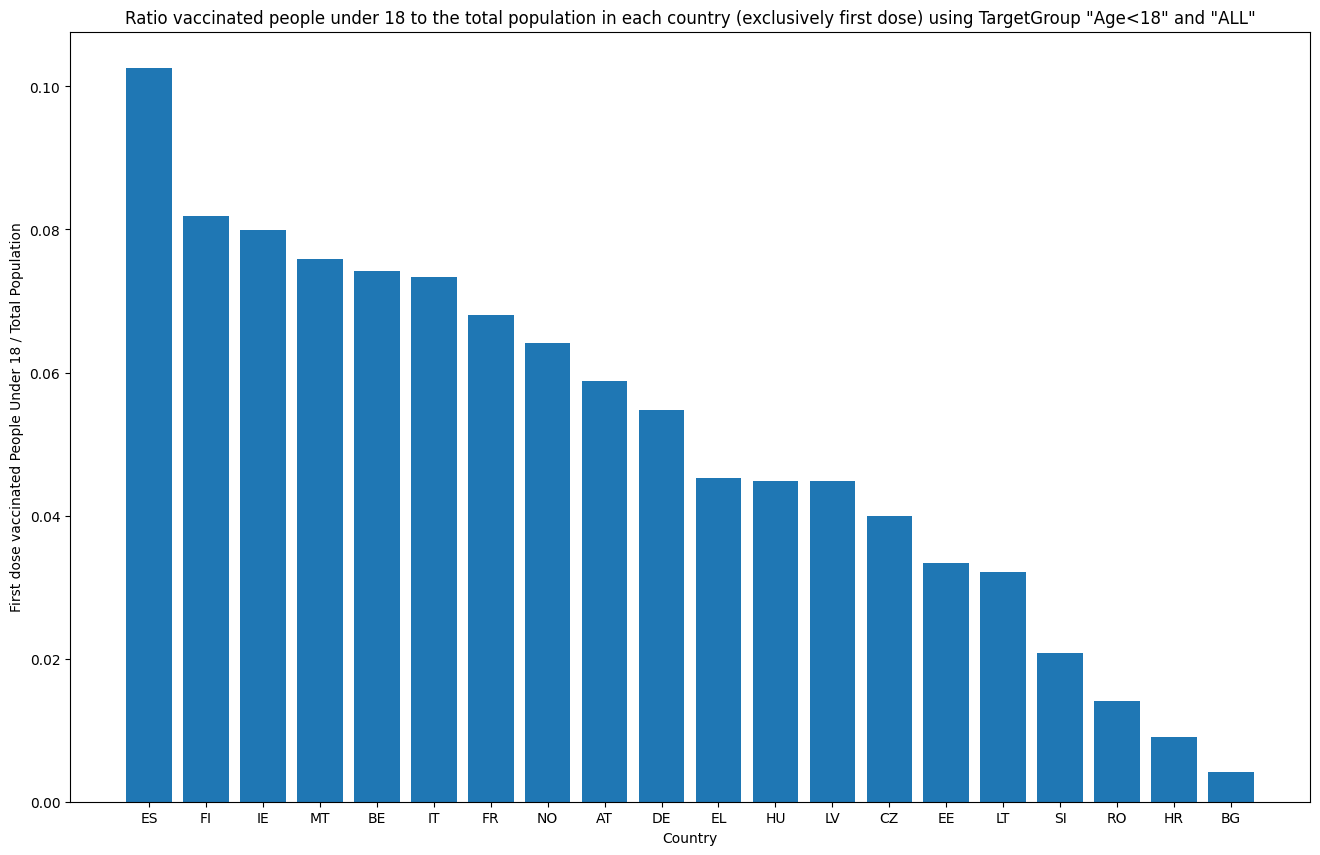

In [35]:
# Get vaccinated under 18 using Age<18 age group and compare to the previous method
vaccinated_under_18_2 = vaccinations_df_clean[vaccinations_df_clean["TargetGroup"] == "Age<18"]

countries_2 = vaccinated_under_18_2["ReportingCountry"].unique() # Get unique countries in the dataset

vaccinated_under_18_per_country_2 = {} # Create empty dict to store vaccinated people under 18 for each country
for country in countries_2: # Loop through each country
    # Sum the first dose vaccines to gather total number of vaccinated (first dose) people under 18 in each country
    vaccinated_under_18_per_country_2[country] = vaccinated_under_18_2[vaccinated_under_18_2["ReportingCountry"] == country]["FirstDose"].sum()

vaccinated_under_18_ratio_per_country_2 = {} # Create empty dict to store vaccinated people under 18/total population ratios for each country
for country in countries_2: # Loop through each country
    # Get the total population of the country
    total_population = vaccinations_df_clean[vaccinations_df_clean["ReportingCountry"] == country]["Population"].iloc[0]
    # Calculate the ratio of vaccinated people under 18 to the total population
    vaccinated_under_18_ratio_per_country_2[country] = vaccinated_under_18_per_country_2[country] / total_population

vaccinated_under_18_ratio_per_country_2 = dict(sorted(vaccinated_under_18_ratio_per_country_2.items(), key=lambda item: item[1], reverse=True))

mpl.figure(figsize=(16, 10))
mpl.bar(vaccinated_under_18_ratio_per_country_2.keys(), vaccinated_under_18_ratio_per_country_2.values())
mpl.title("Ratio vaccinated people under 18 to the total population in each country (exclusively first dose) using TargetGroup \"Age<18\" and \"ALL\"")
mpl.xlabel("Country")
mpl.ylabel("First dose vaccinated People Under 18 / Total Population")
mpl.show()

We do the same as before, but while using the TargetGroup "age<18". Not exactly the same countries are present. This must be because some countries report using "ALL" and "Age<18" for target groups, meanwhile some use the age groups, and some use both methods. We must combine them into one plot using a union to ensure we get both duplicates and those in either one only once.

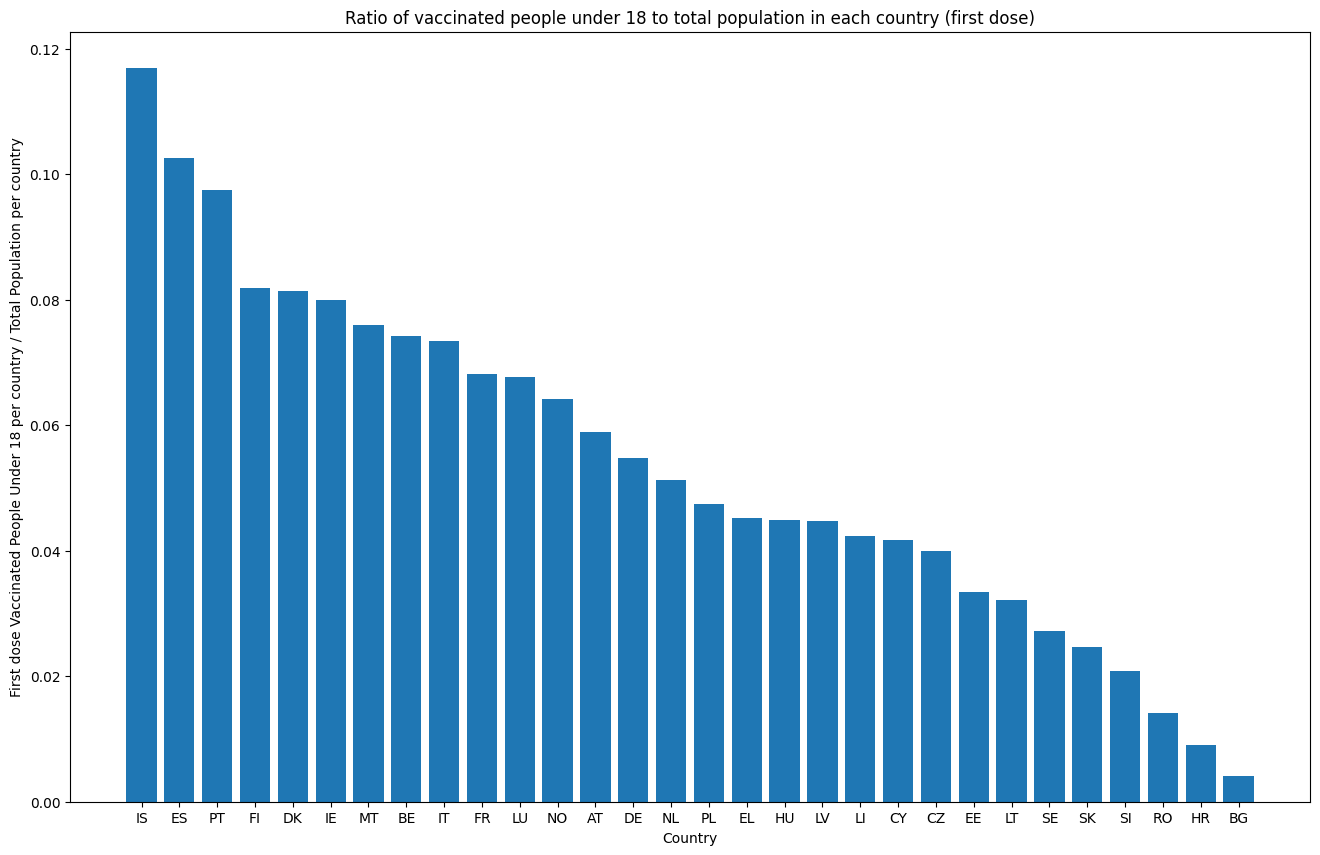

In [36]:
# Combine the two methods to get the final result. If the same country has different values, the maximum value is selected. If the country is not in one of the methods, the value from the other method is selected.
# Create new country list that contains all countries from both methods
countries_final = list(set(countries).union(set(countries_2)))


final_vaccinated_under_18_ratio_per_country = {} # Create empty dict to store the final vaccinated people under 18/total population ratios for each country
for country in countries_final: # Loop through each country
    # If the country is in the first method
    if country in vaccinated_under_18_ratio_per_country:
        # If the country is in the second method
        if country in vaccinated_under_18_ratio_per_country_2:
            # Select the maximum value from the two methods
            final_vaccinated_under_18_ratio_per_country[country] = max(vaccinated_under_18_ratio_per_country[country], vaccinated_under_18_ratio_per_country_2[country])
        else:
            # Select the value from the first method
            final_vaccinated_under_18_ratio_per_country[country] = vaccinated_under_18_ratio_per_country[country]
    else:
        # Select the value from the second method
        final_vaccinated_under_18_ratio_per_country[country] = vaccinated_under_18_ratio_per_country_2[country]

final_vaccinated_under_18_ratio_per_country = dict(sorted(final_vaccinated_under_18_ratio_per_country.items(), key=lambda item: item[1], reverse=True))

mpl.figure(figsize=(16, 10))
mpl.bar(final_vaccinated_under_18_ratio_per_country.keys(), final_vaccinated_under_18_ratio_per_country.values())
mpl.title("Ratio of vaccinated people under 18 to total population in each country (first dose)")
mpl.xlabel("Country")
mpl.ylabel("First dose Vaccinated People Under 18 per country / Total Population per country")
mpl.show()

By using a union of the two previous two country groups we can get a new set of data including all the countries. We then redo the process of calculating the ratios for these countries and plot it. Here we can see that Iceland, Spain and Portugal are the best when it comes to under 18 vaccinated people compared to their total populations for the first dose of the vaccine. Romania, Hungrary and Bulgaria are the worst. Both Bulgaria and Romania had a very low amount of vaccinated people in earlier plots, making this finding unsuprising.

### Which countries have the oldest vaccinated population for the second dose of the COVID-19 vaccine in regards to their total population?

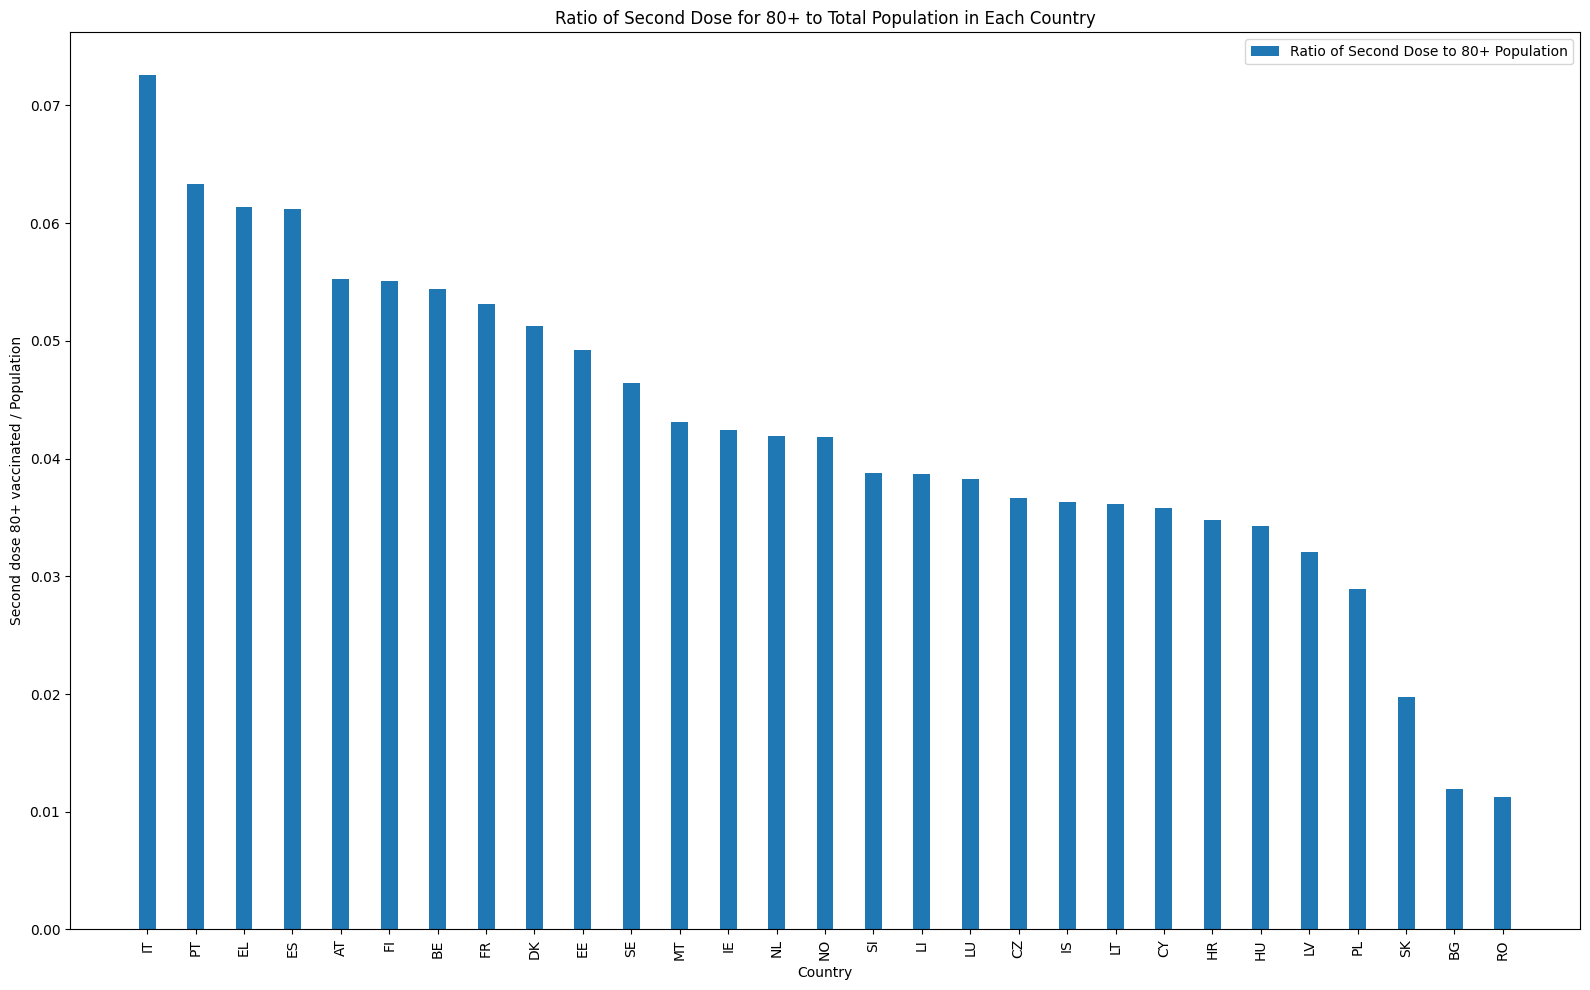

In [37]:
# Filter the data for second dose and target group
vaccinations_80_plus = vaccinations_df_clean[(vaccinations_df_clean['SecondDose'] > 0) & (vaccinations_df_clean['TargetGroup'] == 'Age80+')]

# Calculate ratio of second dose to 80+ population
ratio_80_plus = {} # Create empty dict to store ratio of second dose to 80+ population for each country
for country in vaccinations_80_plus['ReportingCountry'].unique(): # Loop through each country
    total_population = vaccinations_80_plus[(vaccinations_80_plus['ReportingCountry'] == country) & (vaccinations_80_plus['Region'] == country)]['Population'].max() # Get the total population of the country
    total_second_doses = vaccinations_80_plus[(vaccinations_80_plus['ReportingCountry'] == country) & (vaccinations_80_plus['Region'] == country)]['SecondDose'].sum() # Get the total number of second doses for the country
    ratio_80_plus[country] = total_second_doses / total_population # Calculate the ratio of second dose to 80+ population

# Sort the dictionary from highest to lowest ratio
ratio_80_plus = dict(sorted(ratio_80_plus.items(), key=lambda item: item[1], reverse=True))

# Define the bar width and positions
bar_width = 0.35 
index = np.arange(len(ratio_80_plus)) # Create an array of indexes for the countries

# Plot the ratio of second dose to 80+ population on the first subplot
mpl.figure(figsize=(16, 10))
mpl.bar(index, ratio_80_plus.values(), bar_width, label='Ratio of Second Dose to 80+ Population')
mpl.xlabel('Country')
mpl.ylabel('Second dose 80+ vaccinated / Population')
mpl.title('Ratio of Second Dose for 80+ to Total Population in Each Country')
mpl.xticks(index, ratio_80_plus.keys(), rotation=90) # Set the x-ticks to the country names
mpl.legend()
mpl.tight_layout()
mpl.show()

We filter the vaccination data to focus on the second dose given to the 80+ age group. Then we calculate the ratio of second doses to the total population for each country, storing these ratios in a dictionary. The dictionary is sorted in descending order to highlight the countries with the highest vaccination ratios.

When examining the graph there are four main outliers. Italy seems to be the country with by far the greatest ratio of vaccinated 80+ people compared to total population. There are also three countries with exceptionally low numbers. Slovakia, Bulgaria and Romania. Both Bulgaria and Romania was in the worst three when it comes to first dose vaccinations for people under 18. This could indicate that they aren't as good as other countries when it comes to vaccinating their populations, or that their populations don't want to get vaccinated in the same degree as other countries peoples. They also had the lowest amount of percent of first dose vaccinations.  

### Which countries’ health care was most affected by the coronavirus pandemic in 2020 compared to others? How are these statistics in 2022?

C:\Users\abod1\AppData\Local\Temp\ipykernel_21096\675438788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_new_hospital_admissions['year_week'] = weekly_new_hospital_admissions['year_week'].astype(str)


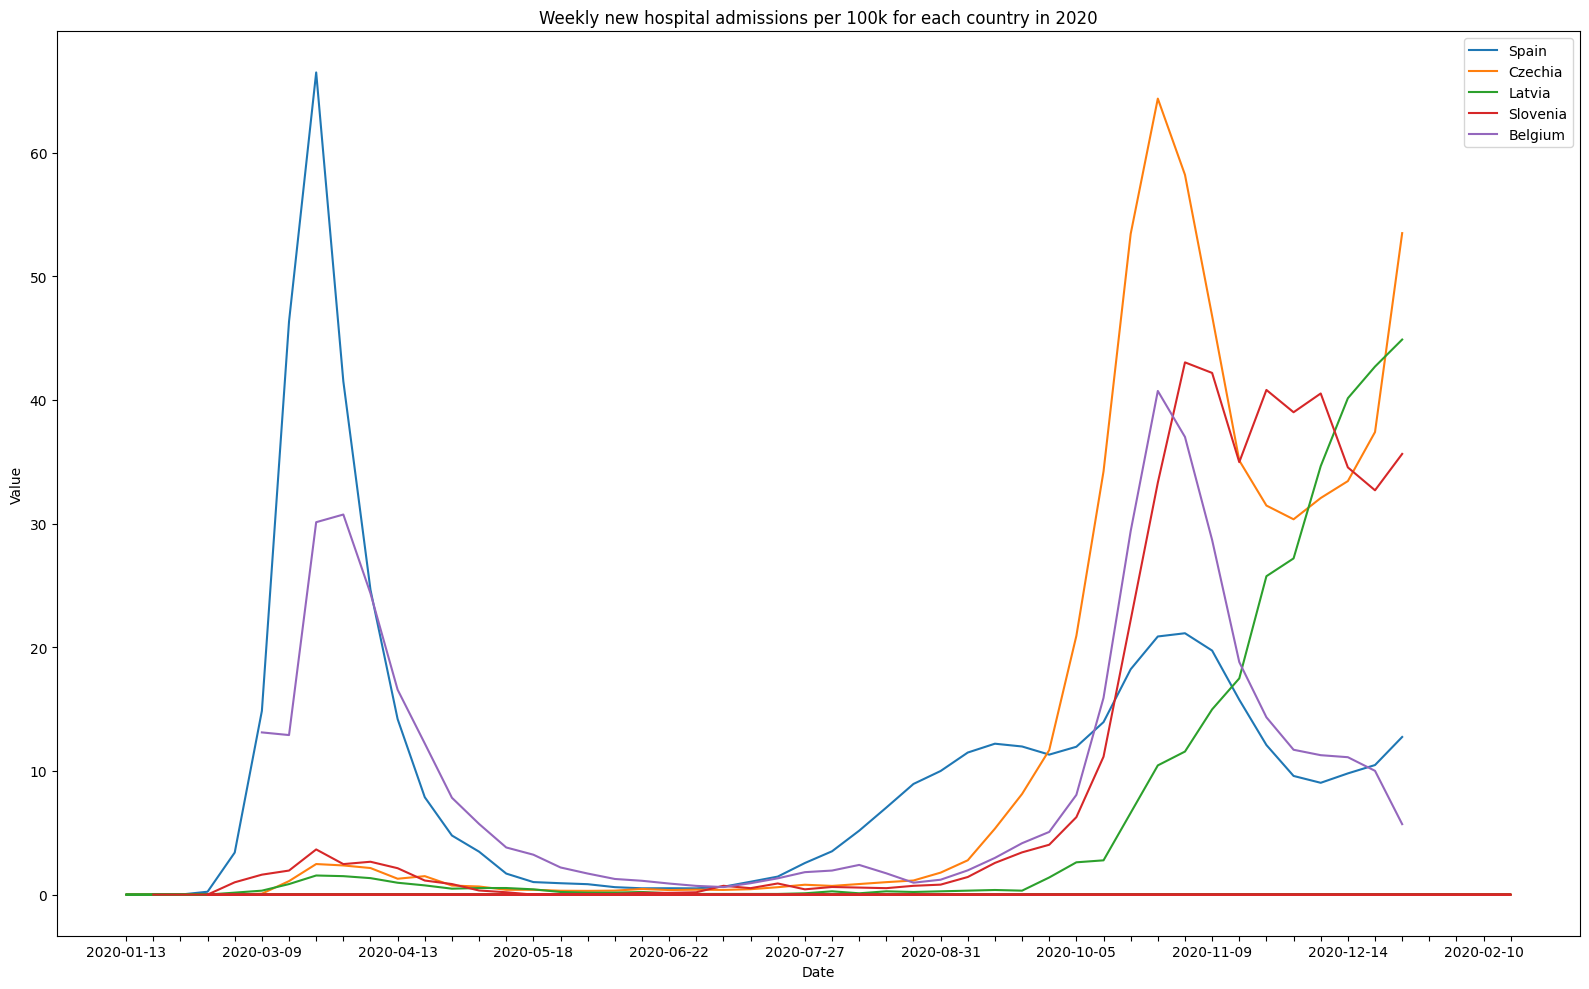

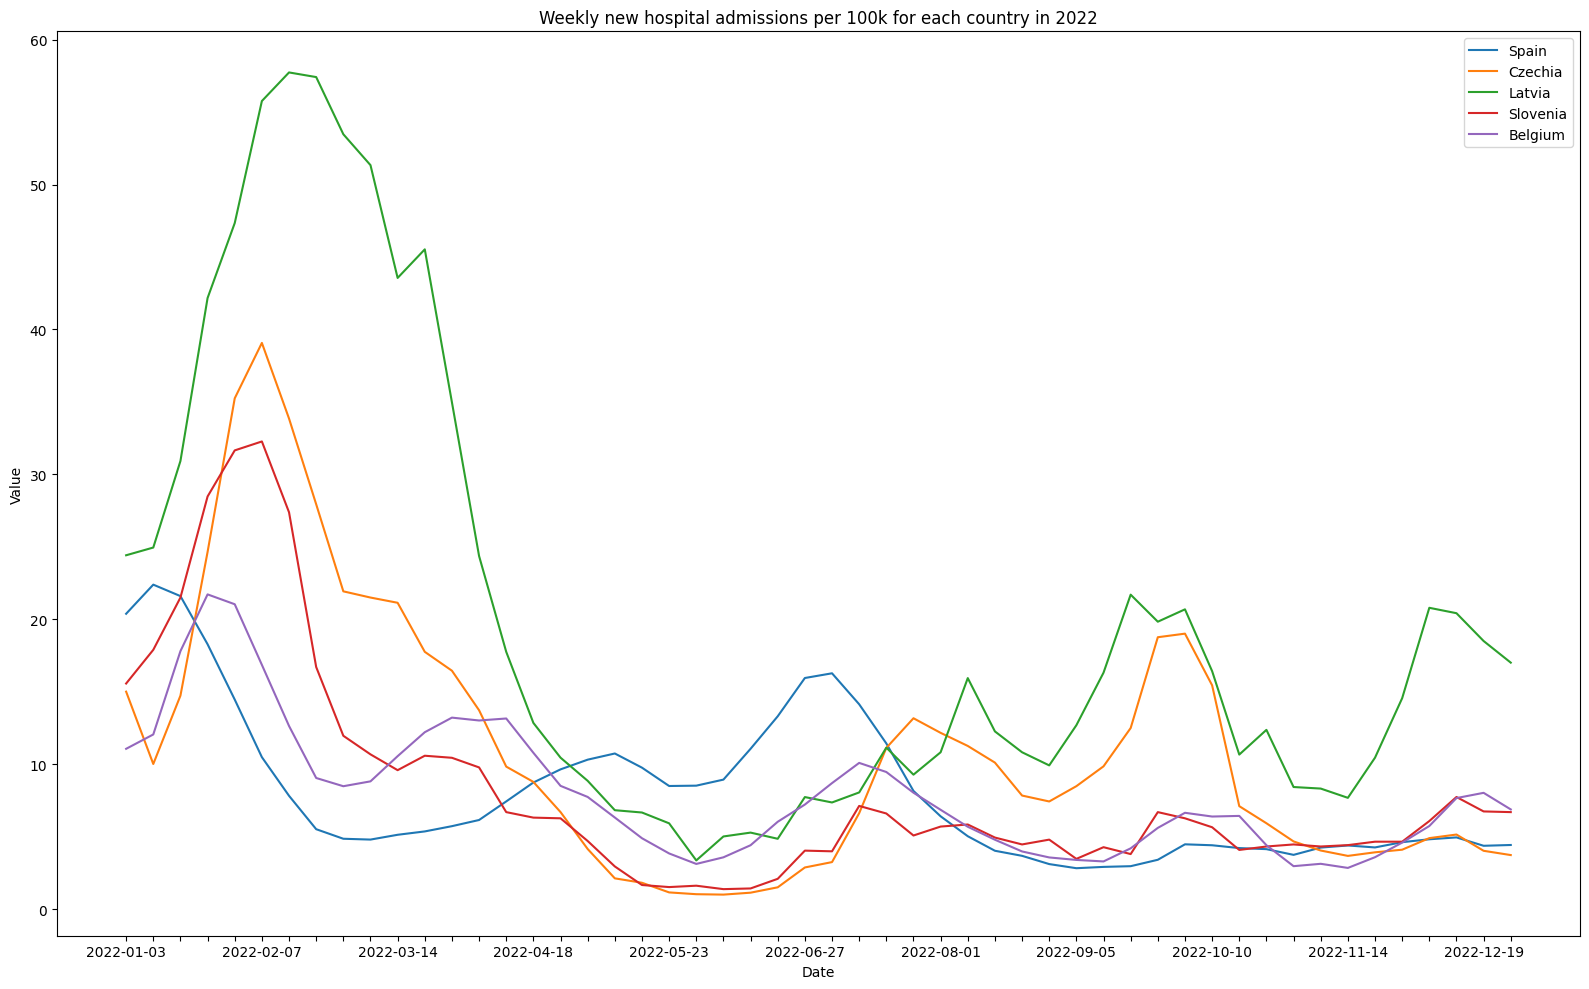

In [38]:
# --- Weekly new hospital admissions per 100k ---
weekly_new_hospital_admissions = hosipital_df_clean[hosipital_df_clean["indicator"] == "Weekly new hospital admissions per 100k"]

weekly_new_hospital_admissions['year_week'] = weekly_new_hospital_admissions['year_week'].astype(str)
weekly_new_hospital_admissions_2020 = weekly_new_hospital_admissions[weekly_new_hospital_admissions['year_week'].str.contains('2020')]

# Find the top 5 countries with the highest maximum weekly new hospital admissions in 2020
top_5_countries_2020 = weekly_new_hospital_admissions_2020.groupby("country")["value"].max().sort_values(ascending=False).head(5)

# plot these 5 countries during 2020
mpl.figure(figsize=(16, 10))
for country in top_5_countries_2020.index:
    country_data = weekly_new_hospital_admissions_2020[weekly_new_hospital_admissions_2020['country'] == country]
    mpl.plot(country_data["year_week"], country_data["value"], label=country)
mpl.title("Weekly new hospital admissions per 100k for each country in 2020")
mpl.xlabel("Date")
mpl.ylabel("Value")
mpl.legend()
mpl.tight_layout()
# Display only every nth label
n = 5  # Change this to display more or fewer labels
[l.set_visible(False) for (i,l) in enumerate(mpl.gca().xaxis.get_ticklabels()) if i % n != 0]
mpl.show()

# How are these 5 countries faring in 2022?
weekly_new_hospital_admissions_2022 = weekly_new_hospital_admissions[weekly_new_hospital_admissions['year_week'].str.contains('2022')]
mpl.figure(figsize=(16, 10))
for country in top_5_countries_2020.index:
    country_data = weekly_new_hospital_admissions_2022[weekly_new_hospital_admissions_2022['country'] == country]
    mpl.plot(country_data["year_week"], country_data["value"], label=country)
mpl.title("Weekly new hospital admissions per 100k for each country in 2022")
mpl.xlabel("Date")
mpl.ylabel("Value")
mpl.legend()
mpl.tight_layout()
# Display only every nth label
n = 5  # Change this to display more or fewer labels
[l.set_visible(False) for (i,l) in enumerate(mpl.gca().xaxis.get_ticklabels()) if i % n != 0]
mpl.show()


We use the indicator column to filter for data regarding weekly new hpsotial adimissions. Then we grab the 5 countries with the highest peaks, assuming these got hit the worst (since it's a relative value due to it being per 100k). We then plot the data for 2020, followed by the same data but for 2022. This is done to see how the situation is different for these 5 countries in 2022 instead of 2020 (where they were deemed the worst). 

In the plots we can observe that belgium and spain got hit hard in the beginning of the covid pandemic, where their hospital admissions skyrocket to levels of ~30 for Belgium and ~65 Spain at around mid mars. This is quite an early peak, compared to the other 5 highest peaking countries under 2020, which peak later in the year and have values around 3 to 5 at this time. There is then a surge in admissions during mid october, continuing towards the end of the year. Here all countries peak except spain, which gains an increase, but not as substantial as in mars. Belgium peaks more than before at around 40. Slovenia and Latvia reach similar levels. the Czech Republic reach levels of around 60, before dropping of and then surging again towards the very end of the year. 

In 2022 we can see that all of the countries are having their peaks in february at around 20-40 admissions per 100k. The outlier here is Latvia which almost reaches 60. Later in the year there are some local peaks, but it seems like they have a steady flow of admissions and there doesn't seem to occur any extreme surges. The peak in the beginning of the year matches the high levels of cases seen in the last question of this jupyter notebook. And considering that the average number of cases each month was way higher in the beginning of 2022, than at any point during 2020, yet still having the same amount of admissions per 100k makes us believe that vaccination caused lethality rates to drop. Lower lethality rates could explain why less people have to go the hospital even though more people are sick.

C:\Users\abod1\AppData\Local\Temp\ipykernel_21096\3062032047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_new_ICU_admissions['year_week'] = weekly_new_ICU_admissions['year_week'].astype(str)


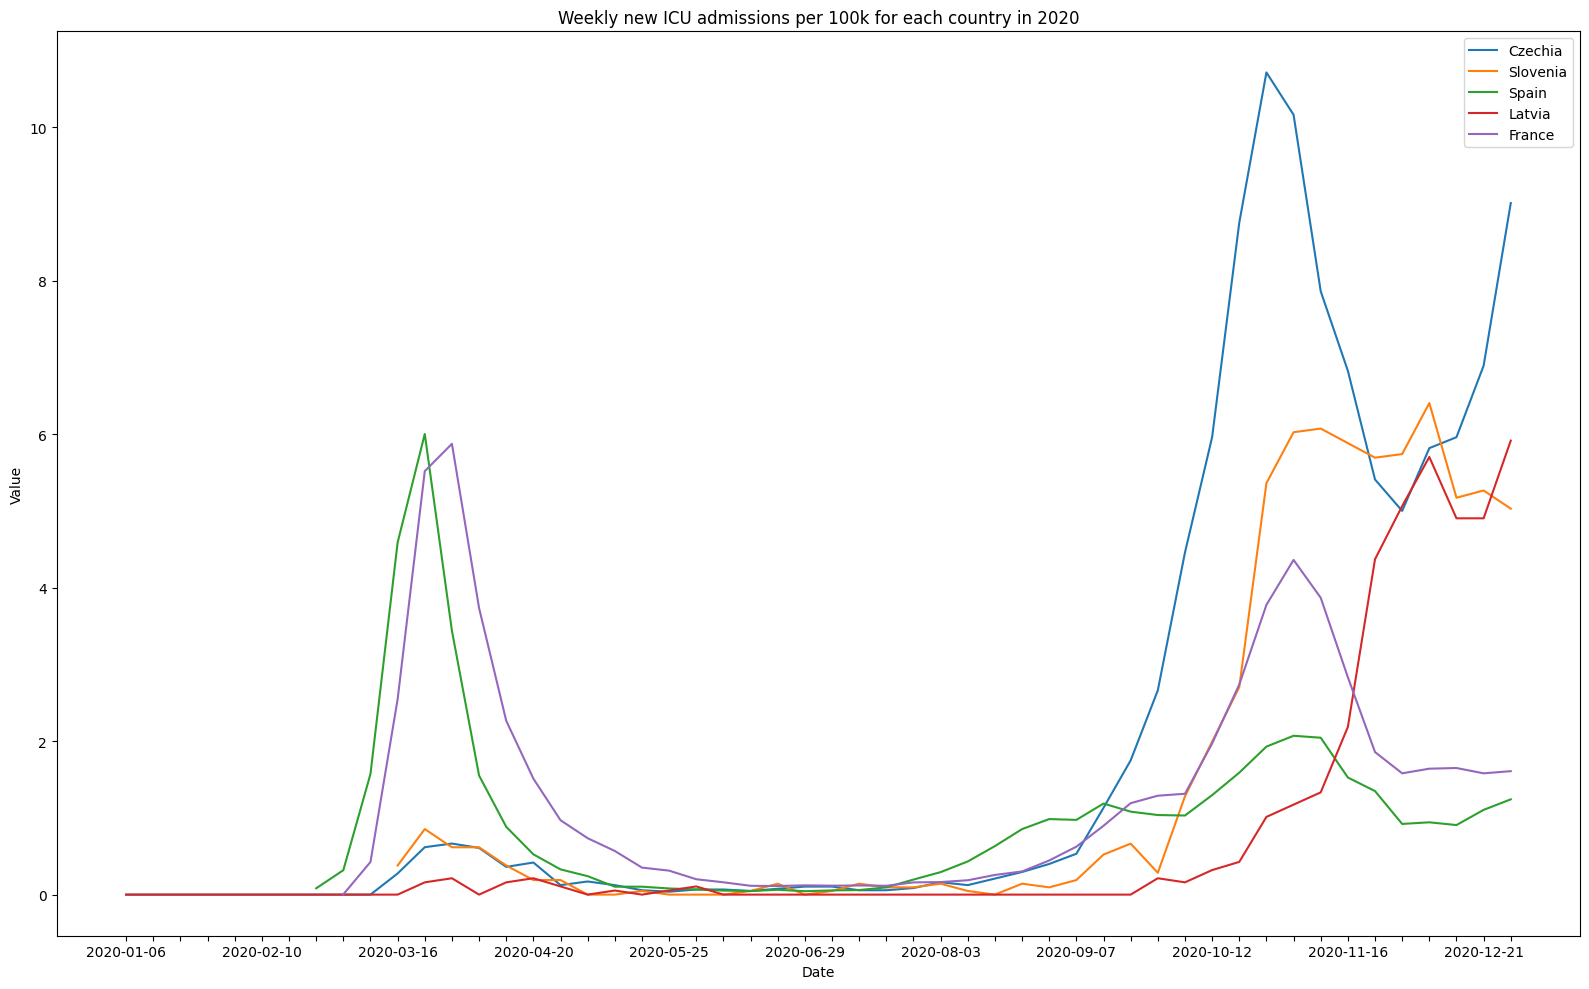

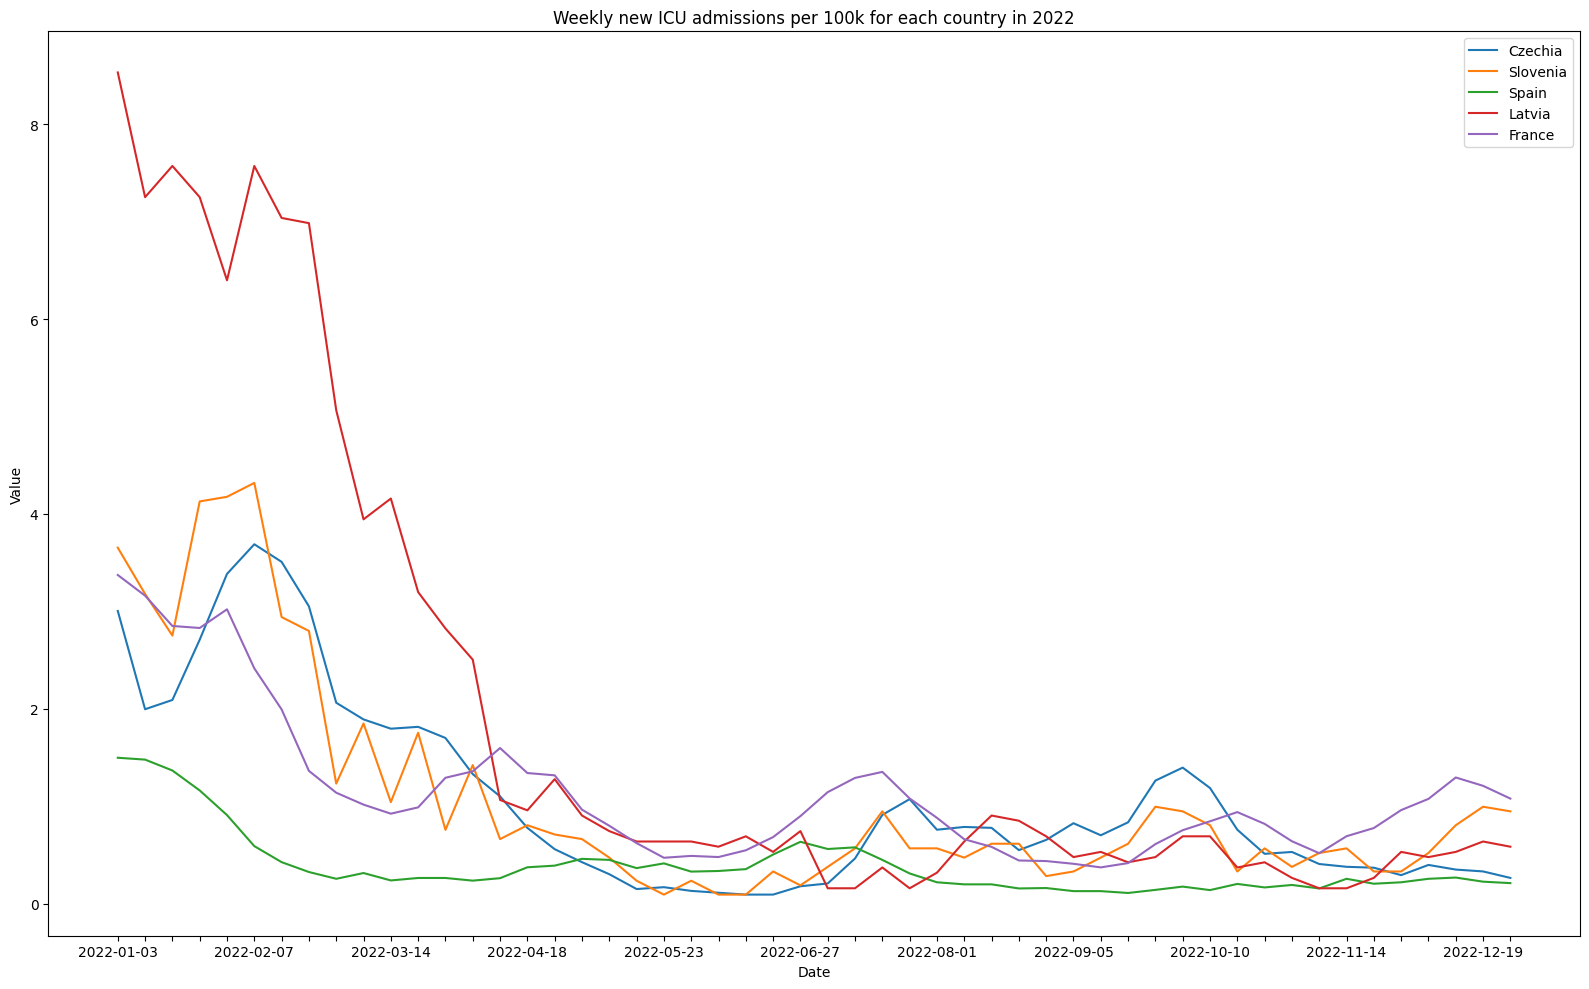

In [39]:
# --- Weekly new ICU new admissions of COVID-19 patients per 100k ---
weekly_new_ICU_admissions = hosipital_df_clean[hosipital_df_clean["indicator"] == "Weekly new ICU admissions per 100k"]

weekly_new_ICU_admissions['year_week'] = weekly_new_ICU_admissions['year_week'].astype(str)
weekly_new_ICU_admissions_2020 = weekly_new_ICU_admissions[weekly_new_ICU_admissions['year_week'].str.contains('2020')]

# Find the top 5 countries with the highest maximum weekly new ICU admissions in 2020
top_5_countries_ICU_2020 = weekly_new_ICU_admissions_2020.groupby("country")["value"].max().sort_values(ascending=False).head(5)

# plot these 5 countries during 2020
mpl.figure(figsize=(16, 10))
for country in top_5_countries_ICU_2020.index:
    country_data = weekly_new_ICU_admissions_2020[weekly_new_ICU_admissions_2020['country'] == country]
    mpl.plot(country_data["year_week"], country_data["value"], label=country)
mpl.title("Weekly new ICU admissions per 100k for each country in 2020")
mpl.xlabel("Date")
mpl.ylabel("Value")
mpl.legend()
mpl.tight_layout()
# Display only every nth label
n = 5  # Change this to display more or fewer labels
[l.set_visible(False) for (i,l) in enumerate(mpl.gca().xaxis.get_ticklabels()) if i % n != 0]
mpl.show()

# How are these 5 countries faring in 2022?
weekly_new_ICU_admissions_2022 = weekly_new_ICU_admissions[weekly_new_ICU_admissions['year_week'].str.contains('2022')]
mpl.figure(figsize=(16, 10))
for country in top_5_countries_ICU_2020.index:
    country_data = weekly_new_ICU_admissions_2022[weekly_new_ICU_admissions_2022['country'] == country]
    mpl.plot(country_data["year_week"], country_data["value"], label=country)
mpl.title("Weekly new ICU admissions per 100k for each country in 2022")
mpl.xlabel("Date")
mpl.ylabel("Value")
mpl.legend()
mpl.tight_layout()
# Display only every nth label
n = 5  # Change this to display more or fewer labels
[l.set_visible(False) for (i,l) in enumerate(mpl.gca().xaxis.get_ticklabels()) if i % n != 0]
mpl.show()


In the same plot but for ICU admissions per 100k we observe the same countries, except France replaces Belgium. The patterns for ICU admissions is almost the same for each country as for normal admissions. The Czech Republic yet again has the highest peak at the end of 2020, and Latvia yet again has the highest peak in the beginning of 2022. This leads us to believe ICU rates are proportional against hospital admissions, and that as with normal hospitalization rates, they decrease compared to the number of infected people after a few vaccinations. ICU rates actually drops to almost zero during the later part of 2022, the period where there normally is a surge in cases (see last question in notebook). 

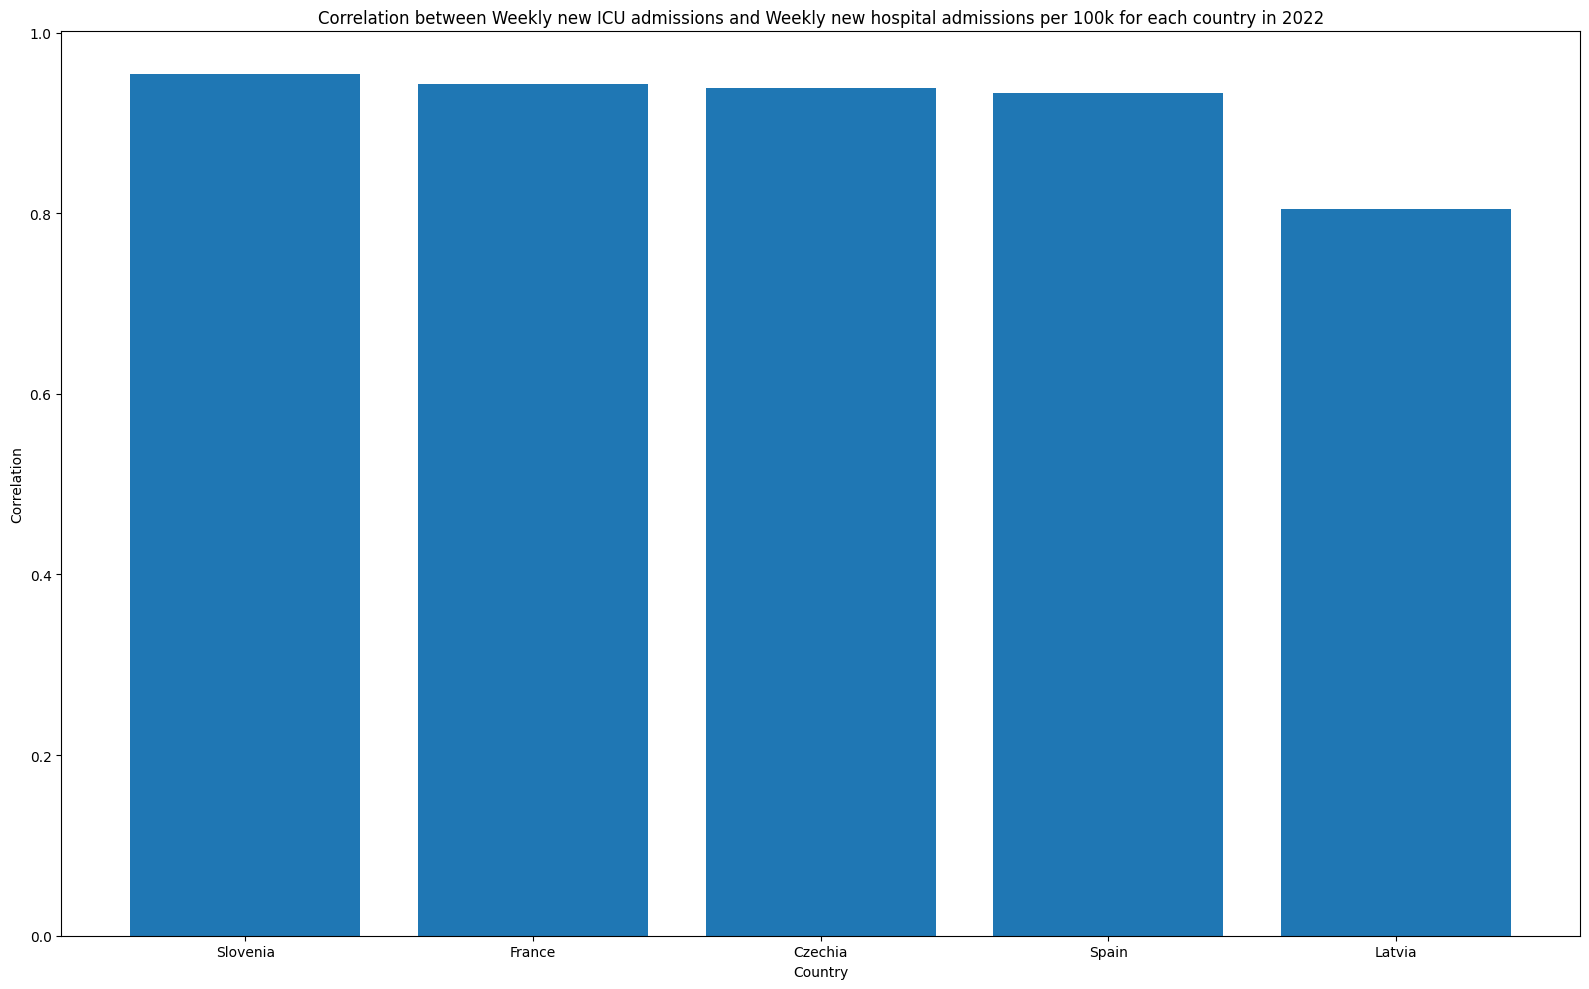

In [40]:
# Is there a correlation between the weekly new hospital admissions and the weekly new ICU admissions?

# Calculate the correlation between the two datasets for 2022
correlation_ICU_hospital = {}
for country in top_5_countries_ICU_2020.index:
    country_data_ICU = weekly_new_ICU_admissions_2022[weekly_new_ICU_admissions_2022['country'] == country]
    country_data_hospital = weekly_new_hospital_admissions_2022[weekly_new_hospital_admissions_2022['country'] == country]
    correlation_ICU_hospital[country] = st.pearsonr(country_data_ICU["value"], country_data_hospital["value"])[0]

# Sort the dictionary from highest to lowest correlation
correlation_ICU_hospital = dict(sorted(correlation_ICU_hospital.items(), key=lambda item: item[1], reverse=True))

# Plot the correlation between the two datasets for 2022
mpl.figure(figsize=(16, 10))
mpl.bar(correlation_ICU_hospital.keys(), correlation_ICU_hospital.values())
mpl.title("Correlation between Weekly new ICU admissions and Weekly new hospital admissions per 100k for each country in 2022")
mpl.xlabel("Country")
mpl.ylabel("Correlation")
mpl.tight_layout()
mpl.show()


There seem to be a very strong correlation between weekly hospital admissions and weekly ICU hopsital admissions. Even though correlation doesn't equal causation, there is likely a direct proportionality bvetween normal and ICU admissions.

### Which country should you be in to have the lowest risk of dying from covid-19?
Motivation: Is an interesting question that undobtedly fullfills the requirement "Furthermore, the questions need to provide some valuable knowledge, e.g., for the public regarding COVID-19 and its effects on EU/EEA countries.", since it is of utmost proiority to being able to make an informed decision for where you as a living being has the lowest risk of mortality.

To analyse this we will calculate the death rate per country during 2022, since this is the most recent data and should be of more use now than data from for example 2020. This is because countries generally should have perfected their planning and handling of covid now compared to earlier during the panedmic, making newer data more fair to the current situation.

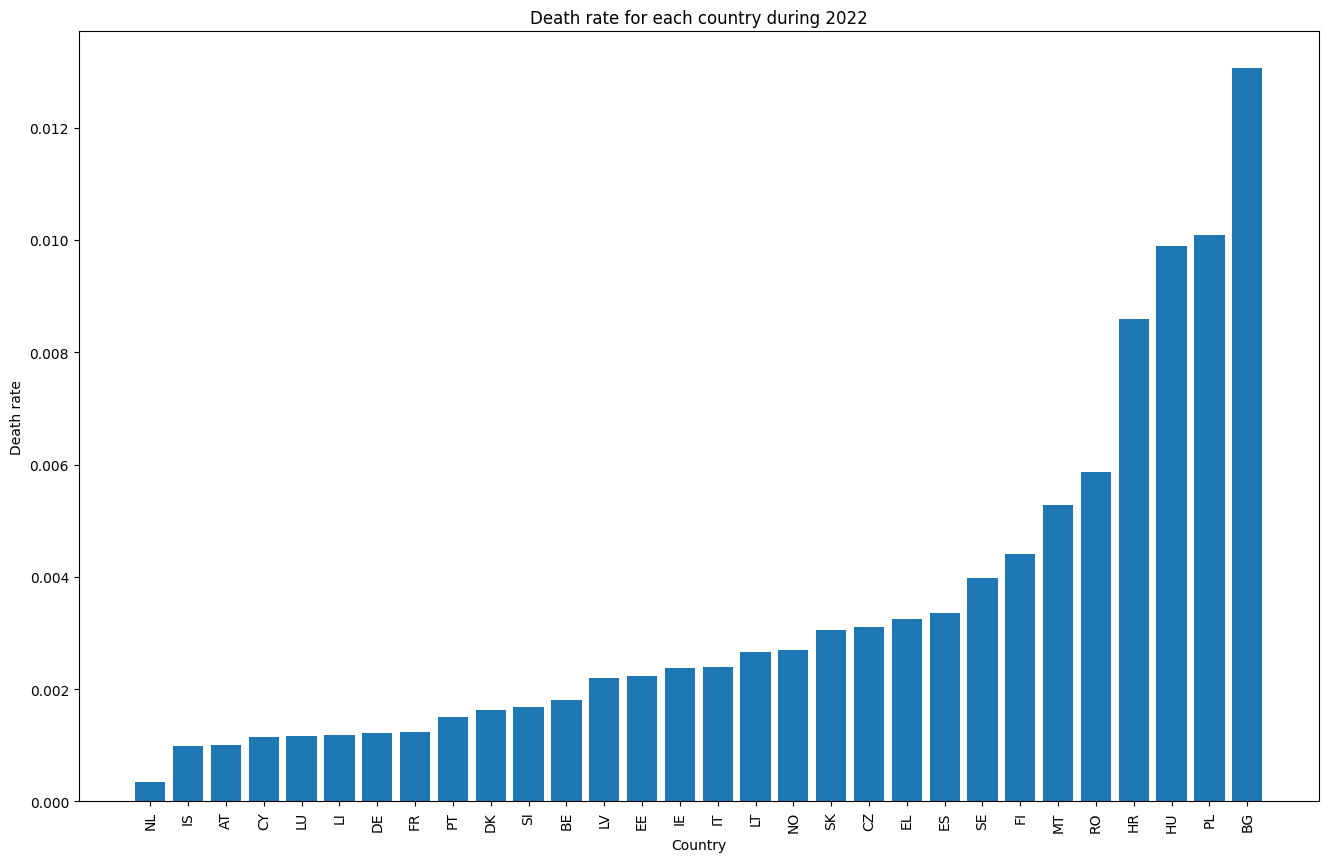

In [41]:

# --------- Calculate which countries provide the lowest risk of dying of covid-19 (any age group) in 2022---------
# Get the total number of deaths for each country during 2022
total_deaths_per_country_2022 = death_case_df_clean[(death_case_df_clean['year'] == 2022)].groupby('geoId')['deaths'].sum()
# Get the total number of cases for each country during 2022
total_cases_per_country_2022 = death_case_df_clean[(death_case_df_clean['year'] == 2022)].groupby('geoId')['cases'].sum()
# Calculate the death rate for each country during 2022
death_rate_per_country_2022 = total_deaths_per_country_2022 / total_cases_per_country_2022
# Sort the dictionary from lowest to highest death rate
death_rate_per_country_2022 = dict(sorted(death_rate_per_country_2022.items(), key=lambda item: item[1]))

# Plot the death rate for each country during 2022
mpl.figure(figsize=(16, 10))
mpl.bar(death_rate_per_country_2022.keys(), death_rate_per_country_2022.values())
mpl.title("Death rate for each country during 2022")
mpl.xlabel("Country")
mpl.ylabel("Death rate")
mpl.xticks(rotation=90)
mpl.show()

First we filter the deahts and cases data for data from 2022, group it by geoId (ISO country code), and the deaths and cases. Then the ratio of deaths per cases is calculated. This should reveal how often a case leads to a death in each country. From the graph we can see that the Netherlands by far have the lowest death per cases ratio during 2022. Based on this it would be safe to say that the Netherlands would have been the safest place to get covid in, in 2022. Since this is the latest data available we assume this is the most accurate data to present time.

### Does the amount of vaccinated people per 100k population have any correlation to the number of deaths per 100k
Motivation: Arguably the most interesting and probably the most debated question in the public space. Some people don't trust that vaccines work, and proving or disproving any correlation between them would be of great benefit to the public and for whether or not it's a viable strategy to combat epidemics. Thusly it certainly fulfills the requirement "Furthermore, the questions need to provide some valuable knowledge, e.g., for the public regarding COVID-19 and its effects on EU/EEA countries.". It will also makes use of two of the datasets, so it also fullfills the requirement "One (1) of the questions must be based on the combination of at least two of the provided datasets." 

We will begin by plotting vaccinations and deaths per 100k per week, in order to examine if there are any visible patterns in the graphs.

C:\Users\abod1\AppData\Local\Temp\ipykernel_21096\1282452923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_week_filtered["YearWeekISO"] = deaths_week_filtered["dateRep"].dt.strftime('%G-W%V')
C:\Users\abod1\AppData\Local\Temp\ipykernel_21096\1282452923.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccinations_week_filtered["YearWeekISO"] = vaccinations_week_filtered["YearWeekISO"].dt.strftime('%G-W%V')


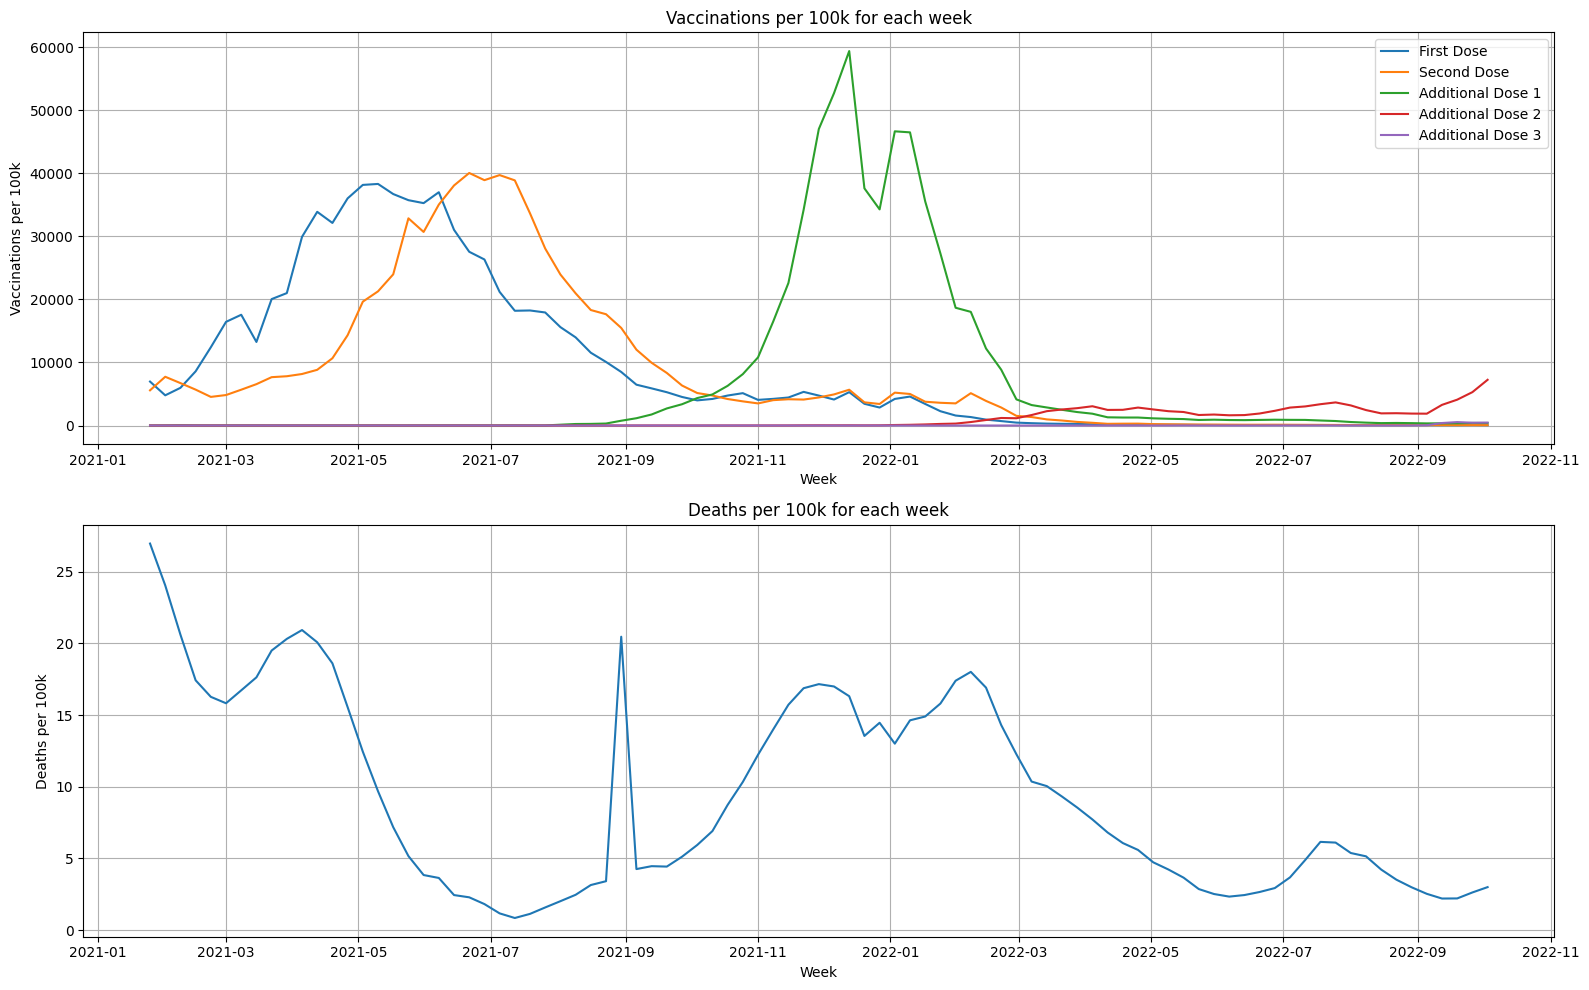

In [42]:
# Get selected countries list. All country tags that are present in geoId and ReportingCountry columns are selected.
selected_countries = list(set(death_case_df_clean["geoId"].unique()).intersection(set(vaccinations_df_clean["ReportingCountry"].unique())))
# selected_countries = ["SE"]

# Start date for the analysis will be 2021-01-25 (ISO week 4 start date) since this is the latest of the "first" dates countries started reporting on vaccinations
start_date = pd.to_datetime("2021-01-25")
# End date for the analysis will be 2022-10-10 since this marks the end of the last ISO week in the deaths dataset
end_date = pd.to_datetime("2022-10-10")

# Filter for dates between start and end date
vaccinations_week_filtered = vaccinations_df_clean[(vaccinations_df_clean["YearWeekISO"] >= start_date) & (vaccinations_df_clean["YearWeekISO"] <= end_date)]
deaths_week_filtered = death_case_df_clean[(death_case_df_clean["dateRep"] >= start_date) & (death_case_df_clean["dateRep"] <= end_date)]

# Create week columns for deaths_week_filtered and vaccinations_week_filtered using ISO weeks so data is comparable
deaths_week_filtered["YearWeekISO"] = deaths_week_filtered["dateRep"].dt.strftime('%G-W%V')
vaccinations_week_filtered["YearWeekISO"] = vaccinations_week_filtered["YearWeekISO"].dt.strftime('%G-W%V')

# Calculate how many weeks between start and end date
total_weeks = math.ceil((end_date - start_date).days / 7)

# Create dictionaries to store the results
vaccinations_first_100k_dict = {}
vaccinations_second_100k_dict = {}
vaccinations_additional1_100k_dict = {}
vaccinations_additional2_100k_dict = {}
vaccinations_additional3_100k_dict = {}
deaths_100k_dict = {}
i = 0
while i < total_weeks:
    # Calculate the current week
    current_week = start_date + pd.DateOffset(weeks=i)
    # Convert current_week to the same format as the "YearWeekISO" column
    current_week_str = current_week.strftime('%G-W%V')

    # Filter for the current week
    vaccinations_current_week = vaccinations_week_filtered[vaccinations_week_filtered["YearWeekISO"] == current_week_str]
    deaths_current_week = deaths_week_filtered[deaths_week_filtered["YearWeekISO"] == current_week_str]
    
    # Calculate the total population for the current week
    total_population_current_week = vaccinations_current_week["Population"].max()

    # Calculate the total number of vaccinations for the current week
    first_vaccinations_current_week = vaccinations_current_week["FirstDose"].sum()
    second_vaccinations_current_week = vaccinations_current_week["SecondDose"].sum()
    additional1_vaccinations_current_week = vaccinations_current_week["DoseAdditional1"].sum()
    additional2_vaccinations_current_week = vaccinations_current_week["DoseAdditional2"].sum()
    additional3_vaccinations_current_week = vaccinations_current_week["DoseAdditional3"].sum()

    # Calculate the total number of deaths for the current week
    total_deaths_current_week = deaths_current_week["deaths"].sum()

    # Calculate the total number of vaccinations per 100k for the current week
    vaccinations_first_100k = (first_vaccinations_current_week / total_population_current_week) * 100000
    vaccinations_second_100k = (second_vaccinations_current_week / total_population_current_week) * 100000
    vaccinations_additional1_100k = (additional1_vaccinations_current_week / total_population_current_week) * 100000
    vaccinations_additional2_100k = (additional2_vaccinations_current_week / total_population_current_week) * 100000
    vaccinations_additional3_100k = (additional3_vaccinations_current_week / total_population_current_week) * 100000

    # Calculate the total number of deaths per 100k for the current week
    deaths_100k = (total_deaths_current_week / total_population_current_week) * 100000

    # Add the results to the dictionaries
    vaccinations_first_100k_dict[current_week] = vaccinations_first_100k
    vaccinations_second_100k_dict[current_week] = vaccinations_second_100k
    vaccinations_additional1_100k_dict[current_week] = vaccinations_additional1_100k
    vaccinations_additional2_100k_dict[current_week] = vaccinations_additional2_100k
    vaccinations_additional3_100k_dict[current_week] = vaccinations_additional3_100k
    
    deaths_100k_dict[current_week] = deaths_100k

    # Increment the week counter
    i += 1

# Plot all vaccination types per 100k in the same plot, deaths as separate plot (using subplots)
fig, ax = mpl.subplots(2, 1, figsize=(16, 10))

# Plot all vaccination types per 100k in the first subplot
ax[0].plot(list(vaccinations_first_100k_dict.keys()), list(vaccinations_first_100k_dict.values()), label="First Dose")
ax[0].plot(list(vaccinations_second_100k_dict.keys()), list(vaccinations_second_100k_dict.values()), label="Second Dose")
ax[0].plot(list(vaccinations_additional1_100k_dict.keys()), list(vaccinations_additional1_100k_dict.values()), label="Additional Dose 1")
ax[0].plot(list(vaccinations_additional2_100k_dict.keys()), list(vaccinations_additional2_100k_dict.values()), label="Additional Dose 2")
ax[0].plot(list(vaccinations_additional3_100k_dict.keys()), list(vaccinations_additional3_100k_dict.values()), label="Additional Dose 3")
ax[0].set_title("Vaccinations per 100k for each week")
ax[0].set_xlabel("Week")
ax[0].set_ylabel("Vaccinations per 100k")
ax[0].grid(True)
ax[0].legend()

# Plot deaths per 100k in the second subplot
ax[1].plot(list(deaths_100k_dict.keys()), list(deaths_100k_dict.values()))
ax[1].set_title("Deaths per 100k for each week")
ax[1].set_xlabel("Week")
ax[1].set_ylabel("Deaths per 100k")
ax[1].grid(True)

# Adjust the layout
fig.tight_layout()
mpl.show()

Initially, we identify countries that are present in both the death and vaccination datasets to ensure that the analysis only includes countries for which there is complete data. The start and end dates for the analysis are set to when countries started reporting on vaccinations and the last date in the deaths dataset, respectively. The vaccination and death data are then filtered to only include within the set start and end date. A new column is added to both datasets that represents the ISO week of the date, allowing the data to be compared on a weekly basis. The total number of weeks in the analysis period is calculated, and dictionaries are created to store the results of the analysis. For each week, it filters the data for the current week, calculates the total population, the total number of each type of vaccination, and the total number of deaths for the current week. Then the number of each type of vaccination and the number of deaths per 100k people for the current week and stores the results in the dictionaries. Finally, the code plots the vaccination rates and death rates over time. An ordinary time plot was chosen since it best illustrates how our data changes over time, which is the metric we are interested in.

From the Vaccinations/100k and Deaths/100k per week plot, we observed a potential decline in deaths following the administration of vaccinations. This observation suggests a possible relationship between these two variables. However, to confirm this relationship we must look at any possible correlation between them, and quantify its strength and direction. Normal correlation just measures direct correlation, i.e any possible relationship between vaccines going up and deaths going down at an instant time scale. However, vaccinations are not likely do grant instant effect, especially not on country level. A solution to this could be Cross-correlation. Cross-correlation provides a measure of correlation, but where one signal is phase shifted. In this case it allows us to measure how long after a rise in vaccines, a decrease in deaths normally would occur (and how strong the correlation is). This analysis can provide valuable insights into the effectiveness of vaccinations and their role in controlling the pandemic. Therefore, the calculation of cross-correlation is an important step in our analysis.

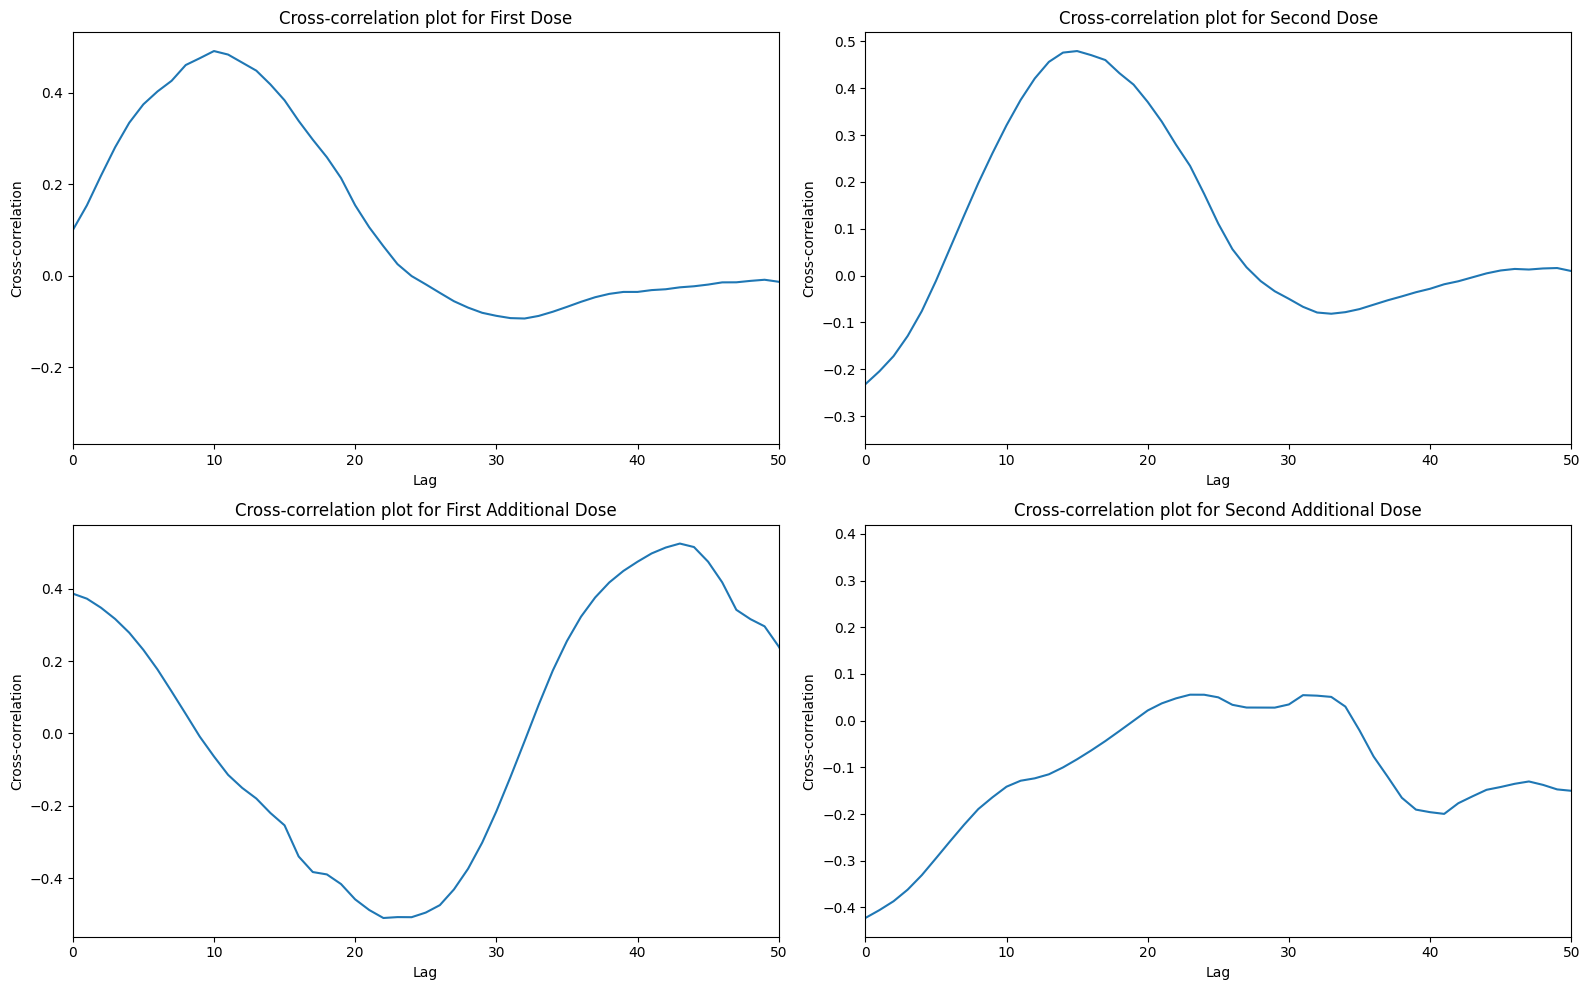

In [43]:
# Create a list of the vaccination dictionaries you're interested in
vaccination_dicts = [vaccinations_first_100k_dict, vaccinations_second_100k_dict, vaccinations_additional1_100k_dict, vaccinations_additional2_100k_dict]
vaccination_dicts_names = ['First Dose', 'Second Dose', 'First Additional Dose', 'Second Additional Dose']

# Create 2x2 subplots
fig, axs = mpl.subplots(2, 2, figsize=(16, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop over all vaccination dictionaries
for i, (vaccinations_dict, ax) in enumerate(zip(vaccination_dicts, axs)):
    # Convert dictionary values to numpy arrays
    vaccinations = np.array(list(vaccinations_dict.values()))
    deaths = np.array(list(deaths_100k_dict.values()))

    # Normalize the signals
    vaccinations = (vaccinations - np.mean(vaccinations)) / (np.std(vaccinations) * len(vaccinations))
    deaths = (deaths - np.mean(deaths)) / (np.std(deaths))

    # Compute cross-correlation
    cross_correlation = correlate(vaccinations, deaths)

    # Compute time lags
    lags = np.arange(-len(deaths) + 1, len(vaccinations))

    # Plot cross-correlation
    ax.plot(lags, cross_correlation)
    ax.set_title(f'Cross-correlation plot for {vaccination_dicts_names[i]}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Cross-correlation')
    ax.set_xlim([0, 50])

mpl.tight_layout()
mpl.show()

As suspected there seem to be a delayed correlation between more vaccines and less deaths per 100k. For the first dose, there seem to be a just shy of ~0.5 peak in correlation at around 10 weeks post vaccination. The second dose has around the same correlation value, but it further delayed at a delay of around 15 weeks. The first additional dose after the first two doses seem to have an instant correlation at around 0.4, and also post 40 weeks it seem to have a large correlation value too. This is very far away from the actual vaccination though, and is unlikely caused by the actual first additional dose, but might rather be caused by the death data declining here (but due to other factors, perhaps the next dose). The second additional dose doesn't seem to have any actual correlation, except a opposite one. This is however likely due to the already low death rates, and low amount of data of additional doses, making just slight changes appear as correlations. This might also be why the plot for the second additional dose is so inconsistent and generally doesn't show any great peaks, as the earlier ones did. 

It seems like there is a moderate correlation between vaccines increasing and deaths decreasing. For the first two doses the correlation is around 0.5, and the effects of the vaccinations seems to generally vary from between a few to up to 15-20 weeks. Additional doses seems to have a more immediate effect, and further doses seems to have no real correlation towards less deaths. This could be due to further doses being provided in order to build up immunity after the two main "waves" of corona already had passed, explaining no measurable impact. Even though correlation does't equal causation, it's arguably safe to assume there is atleast a moderate proof of vaccinations generally providing a lesser death toll, both when examining the vaccinations and deaths graphs, and when examining the cross-correlation graåhs.

### Is there any pattern for when in during the year people get covid-19. 
Motivation: Understanding seasonal patterns in COVID-19 transmission can provide important insights for the public when it comes to the ability to plan according to covid. Wether it be when your aunt should invite a larger amount of people over for cookies, or how the healthcare should properly prepare. Identifying periods of higher covid rates can help allocation of resources in society and prepare the healthcare for potential surges in covid cases, thus benefitting the general public. Hence it should fulfill the requirement: "Furthermore, the questions need to provide some valuable knowledge, e.g., for the public regarding COVID-19 and its effects on EU/EEA countries.".

To analyse the pattern in when people get sick, we will plot the average number of cases for each month, during 2020, 2021 and 2022. This should give a clear overview of any potential trends in this area.

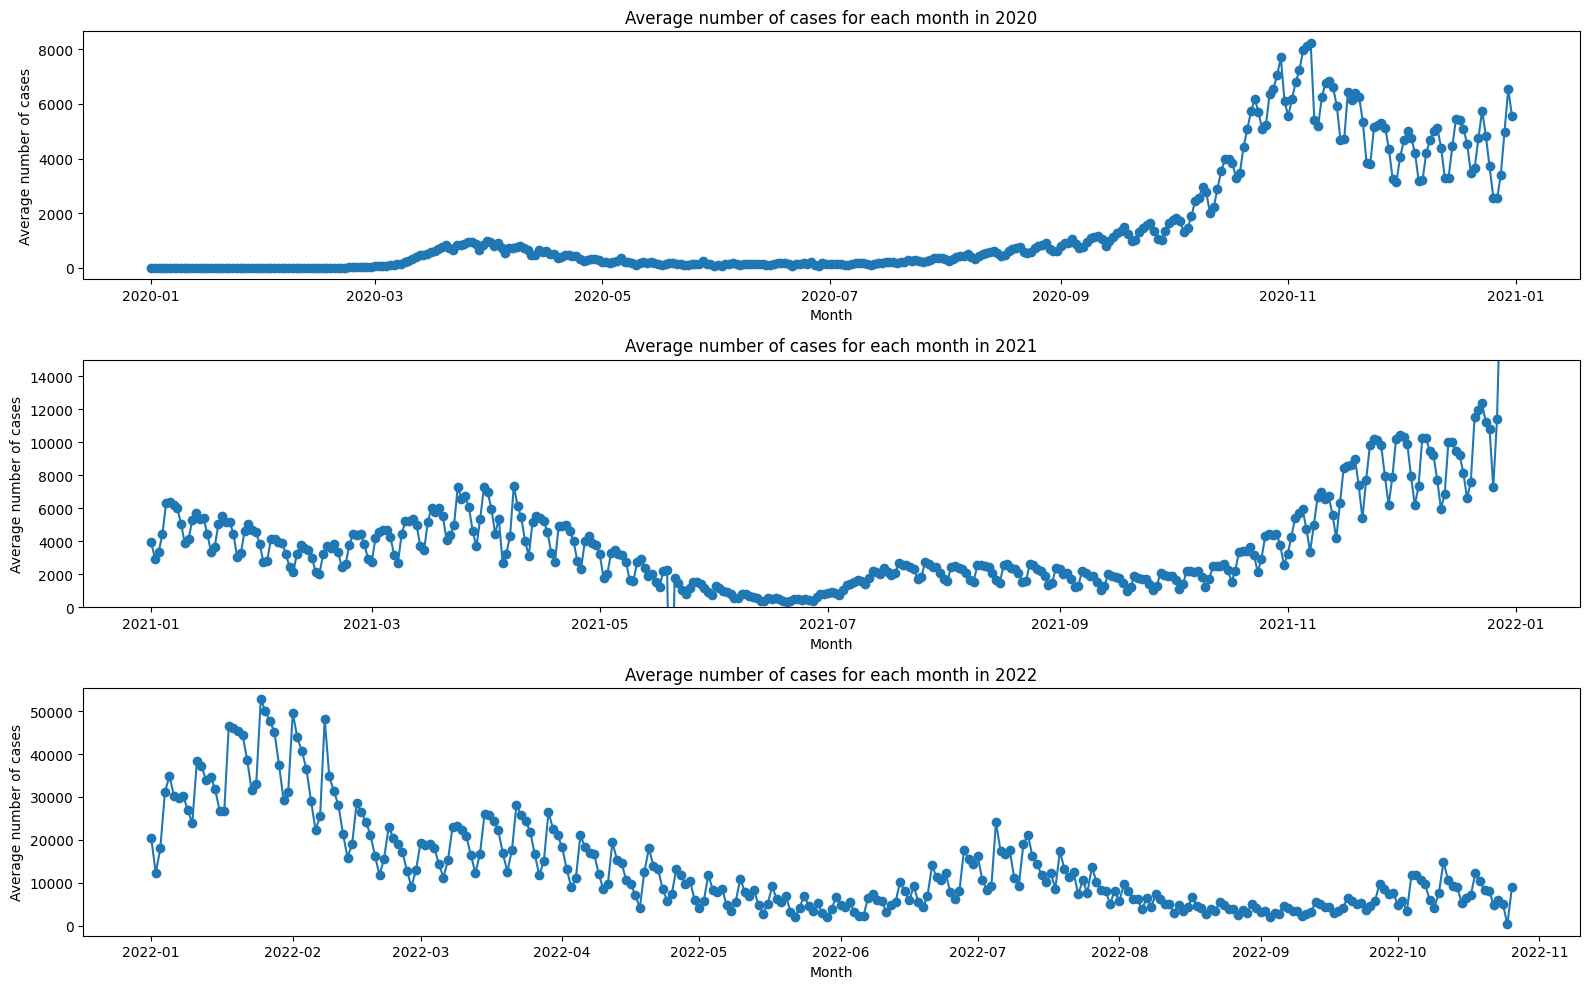

In [44]:
# Is there any pattern for when in the year people get covid-19. 
# Calculate the average number of cases for each month 2020
average_cases_per_month_2020 = death_case_df_clean[(death_case_df_clean['year'] == 2020)].groupby('dateRep')['cases'].mean()
# Calculate the average number of cases for each month 2021
average_cases_per_month_2021 = death_case_df_clean[(death_case_df_clean['year'] == 2021)].groupby('dateRep')['cases'].mean()
# Calculate the average number of cases for each month 2022
average_cases_per_month_2022 = death_case_df_clean[(death_case_df_clean['year'] == 2022)].groupby('dateRep')['cases'].mean()

# Plot in subplots each year
mpl.figure(figsize=(16, 10))
mpl.subplot(3, 1, 1)
mpl.plot(average_cases_per_month_2020.index, average_cases_per_month_2020.values)
mpl.scatter(average_cases_per_month_2020.index, average_cases_per_month_2020.values)
mpl.title("Average number of cases for each month in 2020")
mpl.xlabel("Month")
mpl.ylabel("Average number of cases")
mpl.subplot(3, 1, 2)
mpl.plot(average_cases_per_month_2021.index, average_cases_per_month_2021.values)
mpl.scatter(average_cases_per_month_2021.index, average_cases_per_month_2021.values)
mpl.title("Average number of cases for each month in 2021")
mpl.xlabel("Month")
mpl.ylabel("Average number of cases")
mpl.ylim(0, 15000)
mpl.subplot(3, 1, 3)
mpl.plot(average_cases_per_month_2022.index, average_cases_per_month_2022.values)
mpl.scatter(average_cases_per_month_2022.index, average_cases_per_month_2022.values)
mpl.title("Average number of cases for each month in 2022")
mpl.xlabel("Month")
mpl.ylabel("Average number of cases")
mpl.tight_layout()
mpl.show()

We first calculate the average number of cases for each month for each year. It does this by filtering the data to only include records said year, grouping the data by month, and then calculating the mean number of cases for each month. We then proceed to plot these average monthly case numbers. A line plot shows the trend over time, and a scatter plot fills in the datapoints, further adding to the visualization. 

In the plot we can see a clear trend towards more cases in the colder months. For the last year it might seem like this trend isn't present. This is however quite misleading since closer inspection of the x axis labels reveals that there are no reports after the end of october, right around the time we start to see a upwards trend in the previous years. Likely the trend would be the same. That more people get sick in colder months isn't something new either, other viruses like the flu also affect us more during the winter months. Other research has also found that coronavirus tends to spread less and/or affect the population less in more humid and warm countries, and more in colder climate (for example: Chen, S., Prettner, K., Kuhn, M. et al. Climate and the spread of COVID-19. Sci Rep 11, 9042 (2021). https://doi.org/10.1038/s41598-021-87692-z). 

A observed pattern is thusly that people tend to get sick more during the winter months, and less so during the summer.